In [ ]:
#@title Install Required Packages
!pip install scanpy[leiden]
!pip install scanpy[louvain]
!pip install MulticoreTSNE
!pip install seaborn==0.10.0

In [ ]:
!pip install MAST==2.0.0

  Using cached https://files.pythonhosted.org/packages/17/fc/7e9aff81c2dca212c3bd1787fd167a6f8fd27be373fbc8cbef71ef330408/MAST-2.0.0.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data analysis on Clonal kinetics and single-cell transcriptional profiling of CAR-T cells in patients undergoing CD19 CAR-T immunotherapy https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6954177/

In [ ]:
import scanpy as sc
from pathlib import Path

# set scanpy plotting parameter to dpi = 150
sc.settings.set_figure_params(dpi=150)

In [ ]:
DATA = Path("/content/drive/MyDrive/Colab Notebooks/Final Project_FIG6")

In this project,

GSE125881_raw.expMatrix.csv.gz data is considered the raw scRNA-seq data, from the NCBI GEO under accession number GSE125881.

GSE125881_RAW.tar is another data file.


In [ ]:
#Read the raw expression matrix into a scanpy AnnData object 
#GE is already pre-filtered for mito% >20, unique gene count < 200, UMI count > 40,000
ge = sc.read_csv(
    DATA / "GSE125881_raw.expMatrix.csv.gz"
).transpose()

In [ ]:
ge.shape

(62167, 20223)

In [ ]:
#converted the ge.X matrix to a sparse matrix because processing steps on the dense 
#matrix caused colab to crash
from scipy import sparse

ge.X = sparse.csr_matrix(ge.X)


In [ ]:
#Add in the sample meta data as per the github R code to ge.obs 
import pandas as pd
ge.obs['sample_id'] = [s.split('-')[1] for s in ge.obs_names]
ge.obs['patient'] = ge.obs.sample_id.map({'1':'CLL-1', '2':'CLL-1', '3':'CLL-1', '4':'CLL-1', '5':'NHL-6', 
                                          '6':'NHL-6', '7':'NHL-6', '8':'CLL-2', '9':'CLL-2', '10':'CLL-2', 
                                          '11':'CLL-2', '12':'NHL-7', '13':'NHL-7', '14':'NHL-7', '15':'NHL-7', 
                                          '16':'NHL-6'}
                                         )
ge.obs['time_point'] = ge.obs.sample_id.map({'1':'IP', '2':'d21', '3':'d38', '4':'d112', '5':'d12', 
                                          '6':'d29', '7':'d102', '8':'IP', '9':'d12', '10':'d29', 
                                          '11':'d83', '12':'IP', '13':'d12', '14':'d28', '15':'d89', 
                                          '16':'IP'}
                                         )
ge.obs['group'] = ge.obs.sample_id.map({'1':'IP', '2':'Early', '3':'Late', '4':'Very Late', '5':'Early', 
                                          '6':'Late', '7':'Very Late', '8':'IP', '9':'Early', '10':'Late', 
                                          '11':'Very Late', '12':'IP', '13':'Early', '14':'Late', '15':'Very Late', 
                                          '16':'IP'}
                                       )
ge.obs['patient_point'] = ge.obs.sample_id.map({'1':'CLL-1_IP', '2':'CLL-1_Early', '3':'CLL-1_Late', '4':'CLL-1_Very Late', '5':'NHL-6_Early', 
                                          '6':'NHL-6_Late', '7':'NHL-6_Very Late', '8':'CLL-2_IP', '9':'CLL-2_Early', '10':'CLL-2_Late', 
                                          '11':'CLL-2_Very Late', '12':'NHL-7_IP', '13':'NHL-7_Early', '14':'NHL-7_Late', '15':'NHL-7_Very Late', 
                                          '16':'NHL-6_IP'})
ge.obs['disease'] = [s.split('-')[0] for s in ge.obs.patient]
ge.obs

sample_id patient time_point group patient_point disease
AAACCTGAGCGTCTAT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGCAATAGAGT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGCATGACGGA-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGGTAGTGAAT-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
AAACCTGGTCTCCCTA-1          1   CLL-1         IP    IP      CLL-1_IP     CLL
...                       ...     ...        ...   ...           ...     ...
TTGGAACTCGACAGCC-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTGTAGGAGTTAGGTA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTACTGAGACCACGA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTATGCCAATGAAAC-16        16   NHL-6         IP    IP      NHL-6_IP     NHL
TTTGGTTGTACAAGTA-16        16   NHL-6         IP    IP      NHL-6_IP     NHL

[62167 rows x 6 columns]

In [ ]:
#add percent mito to ge.obs
import numpy as np 
mito_genes = ge.var_names.str.startswith('MT-')
ge.obs['percent_mito'] = np.sum(ge[:, mito_genes].X, axis=1) / np.sum(ge.X, axis=1)
ge.obs

sample_id patient  ... disease percent_mito
AAACCTGAGCGTCTAT-1          1   CLL-1  ...     CLL     0.037927
AAACCTGCAATAGAGT-1          1   CLL-1  ...     CLL     0.084149
AAACCTGCATGACGGA-1          1   CLL-1  ...     CLL     0.049491
AAACCTGGTAGTGAAT-1          1   CLL-1  ...     CLL     0.064682
AAACCTGGTCTCCCTA-1          1   CLL-1  ...     CLL     0.049556
...                       ...     ...  ...     ...          ...
TTGGAACTCGACAGCC-16        16   NHL-6  ...     NHL     0.002561
TTGTAGGAGTTAGGTA-16        16   NHL-6  ...     NHL     0.132093
TTTACTGAGACCACGA-16        16   NHL-6  ...     NHL     0.057638
TTTATGCCAATGAAAC-16        16   NHL-6  ...     NHL     0.160506
TTTGGTTGTACAAGTA-16        16   NHL-6  ...     NHL     0.044797

[62167 rows x 7 columns]

In [ ]:
import numpy as np

sc.pp.filter_cells(ge, min_genes=0)
sc.pp.filter_genes(ge, min_cells=0)

mito_genes = ge.var_names.str.startswith('MT-')

ge.obs['percent_mito'] = np.sum(ge[:, mito_genes].X, axis=1) / np.sum(ge.X, axis=1)
r = np.sum(ge[:,mito_genes].X, axis=1)
p = np.sum(ge.X, axis=1)
ge.obs['n_counts'] = np.ravel(ge.X.sum(axis=1))

In [ ]:
# After adding mito, data from cells of gene counts < 200, percentage of mitochondrial 
# genes > 20% or > 40,000 UMIs were REMOVED (thus 2340 cells discarded)
# The amount of single CAR-T cells for analysis: 62,167 cells, should be same shape as in R
ge.shape

(62167, 20223)

In [ ]:
# Get residuals of single cell expression data - Normalize data
# normalize with CP10K to normalize all counts to 10K per cell
sc.pp.normalize_per_cell(ge, counts_per_cell_after=1e4)
#log trasnform the normalized counts 
sc.pp.log1p(ge)

In [ ]:
ge.obs

sample_id patient  ... n_genes n_counts
AAACCTGAGCGTCTAT-1          1   CLL-1  ...    2500   8780.0
AAACCTGCAATAGAGT-1          1   CLL-1  ...    2549   8782.0
AAACCTGCATGACGGA-1          1   CLL-1  ...    3146  10911.0
AAACCTGGTAGTGAAT-1          1   CLL-1  ...    4310  18042.0
AAACCTGGTCTCCCTA-1          1   CLL-1  ...    4628  24558.0
...                       ...     ...  ...     ...      ...
TTGGAACTCGACAGCC-16        16   NHL-6  ...    1529   4295.0
TTGTAGGAGTTAGGTA-16        16   NHL-6  ...    1481   3172.0
TTTACTGAGACCACGA-16        16   NHL-6  ...    1561   3869.0
TTTATGCCAATGAAAC-16        16   NHL-6  ...    1724   4112.0
TTTGGTTGTACAAGTA-16        16   NHL-6  ...    1643   3661.0

[62167 rows x 9 columns]

In [ ]:
ge.obs.group

AAACCTGAGCGTCTAT-1     IP
AAACCTGCAATAGAGT-1     IP
AAACCTGCATGACGGA-1     IP
AAACCTGGTAGTGAAT-1     IP
AAACCTGGTCTCCCTA-1     IP
                       ..
TTGGAACTCGACAGCC-16    IP
TTGTAGGAGTTAGGTA-16    IP
TTTACTGAGACCACGA-16    IP
TTTATGCCAATGAAAC-16    IP
TTTGGTTGTACAAGTA-16    IP
Name: group, Length: 62167, dtype: object

In [ ]:
#Find highly variable genes
sc.pp.highly_variable_genes(ge,min_mean=0.0125, max_mean=4, min_disp=0.5, flavor='seurat')

In [ ]:
ge.raw = ge 
# Should probably be using ge.raw, as they used the non-corrected one for MAST analysis

In [ ]:
#Filter to only include the highly_variable genes
ge = ge[:, ge.var['highly_variable']]

In [ ]:
#Regress out library effect size and percent mito
# Same effect as MAST R package
sc.pp.regress_out(ge, keys=['n_counts','percent_mito'])

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'time_point' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'patient_point' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'disease' as categorical
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#scale data to univariate
sc.pp.scale(ge, max_value=10)

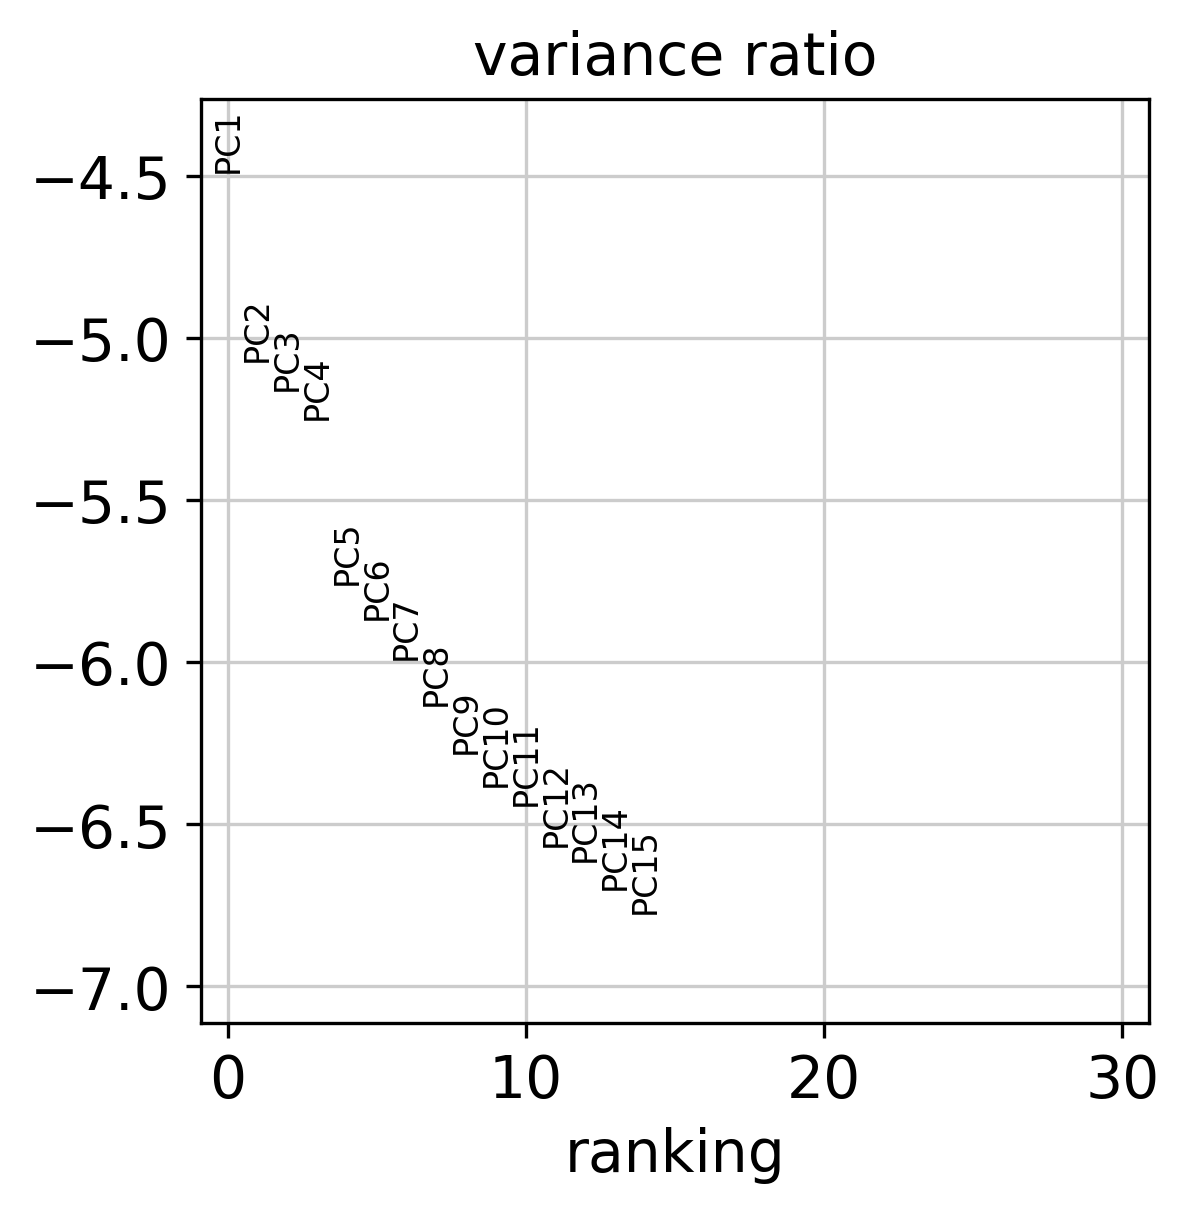

In [ ]:
#Perform PCA on top highly variable genes and plot PCs 
sc.tl.pca(ge, n_comps = 15, svd_solver='arpack')
sc.pl.pca_variance_ratio(ge, log=True)

In [ ]:
sc.pp.neighbors(ge, n_neighbors=10, n_pcs=15)

In [ ]:
sc.tl.leiden(ge)

In [ ]:
sc.tl.tsne(ge)

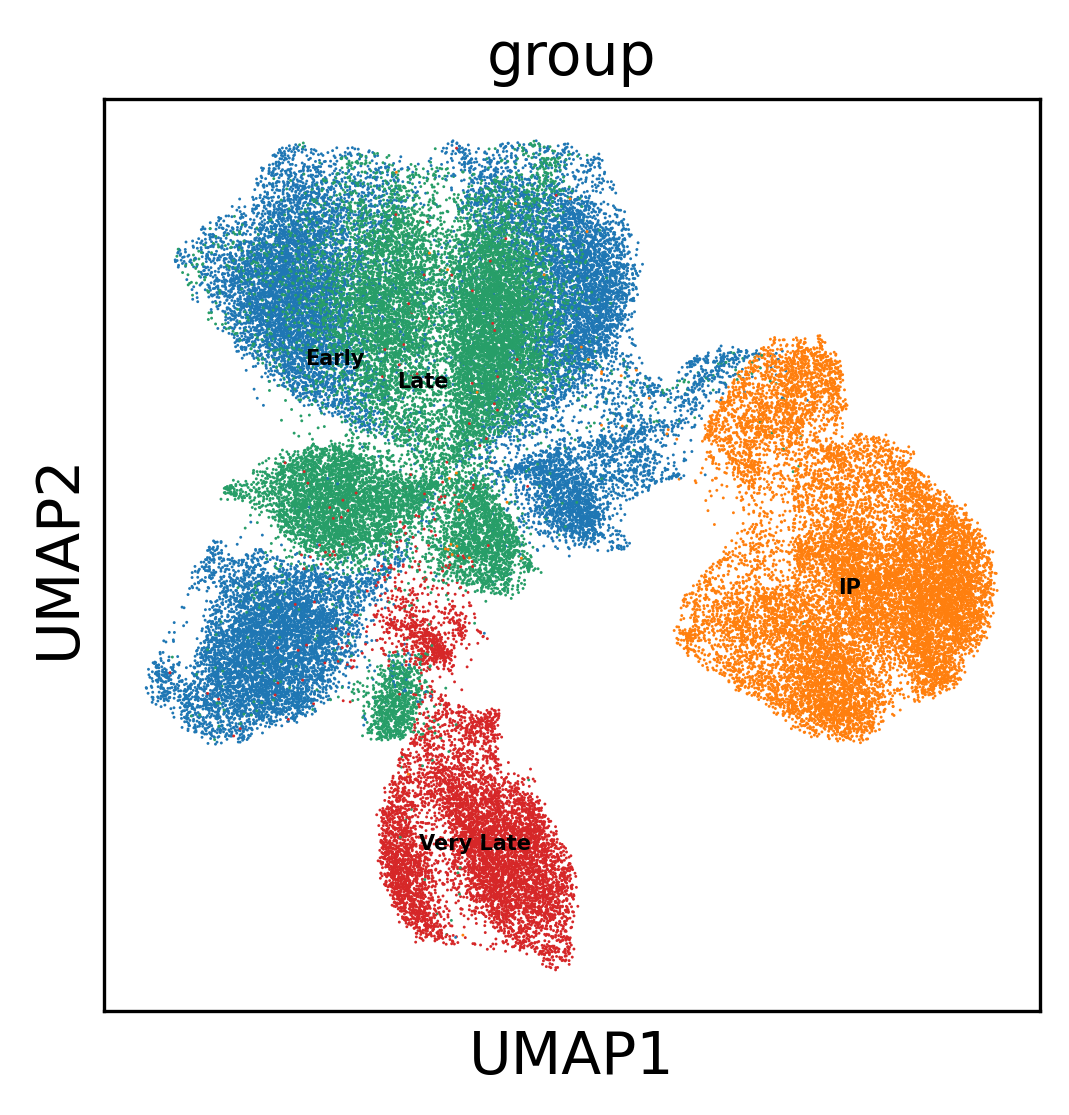

In [ ]:
#Perform UMAP on the nearest neighbors
#plot the UMAP with group as color
#use raw = FALSE to use the corrected data (regressed out and scaled)
sc.tl.umap(ge)
sc.settings.set_figure_params(dpi=150)
sc.pl.umap(ge, color=["group"], legend_loc='on data', legend_fontsize=5, use_raw=False)

In [ ]:
# sc.tl.tsne(ge)
# sc.settings.set_figure_params(dpi=150)

In [ ]:
# sc.pl.tsne(ge, color=['group'], legend_loc='on data', legend_fontsize=5, use_raw=False)

In [ ]:
ge_copy = ge

In [ ]:
ge_copy.obs.head()

sample_id patient time_point  ... n_genes n_counts leiden
AAACCTGAGCGTCTAT-1         1   CLL-1         IP  ...    2500   8780.0      0
AAACCTGCAATAGAGT-1         1   CLL-1         IP  ...    2549   8782.0      0
AAACCTGCATGACGGA-1         1   CLL-1         IP  ...    3146  10911.0      9
AAACCTGGTAGTGAAT-1         1   CLL-1         IP  ...    4310  18042.0      9
AAACCTGGTCTCCCTA-1         1   CLL-1         IP  ...    4628  24558.0      9

[5 rows x 10 columns]

In [ ]:
ge_copy.obsm_keys

<bound method AnnData.obsm_keys of AnnData object with n_obs × n_vars = 62167 × 2685
    obs: 'sample_id', 'patient', 'time_point', 'group', 'patient_point', 'disease', 'percent_mito', 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'group_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

In [ ]:
# Work on Figure B

In [ ]:
# DEG with gene ranking, for only IP
# Logistic regression model used to test DEG rate between groups
# Gaussian generalized linear model described expression continually on non-zero expression estimates
# Requires method='t-test' to generate logfoldchange values

sc.tl.rank_genes_groups(ge, groupby=('patient_point'), method='t-test', use_raw=False)

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [ ]:
# Work on Figure A: PCA

In [ ]:
# sc.tl.pca(ge, n_comps = 15, svd_solver='arpack')

Trying to set attribute `.uns` of view, copying.


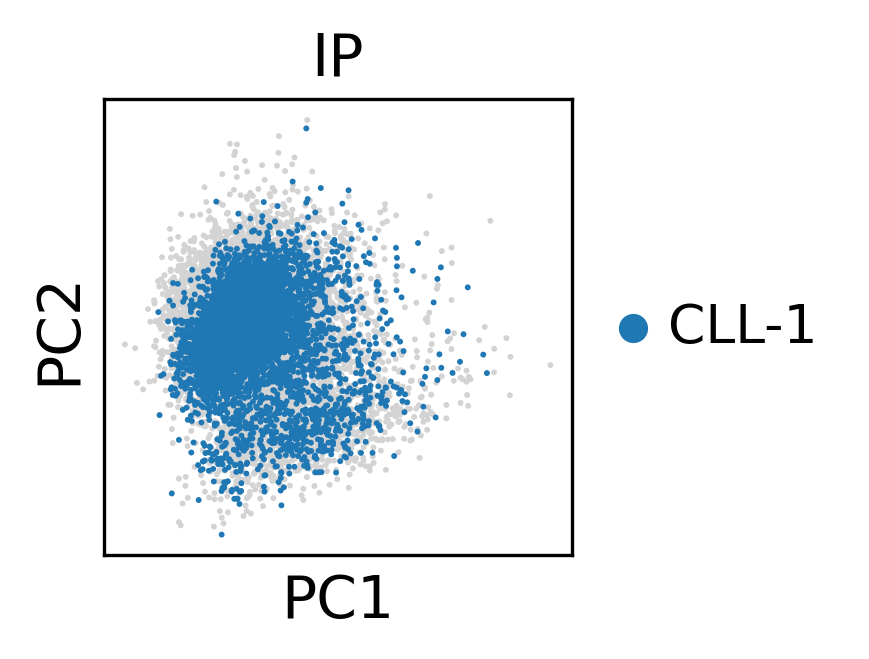

Trying to set attribute `.uns` of view, copying.


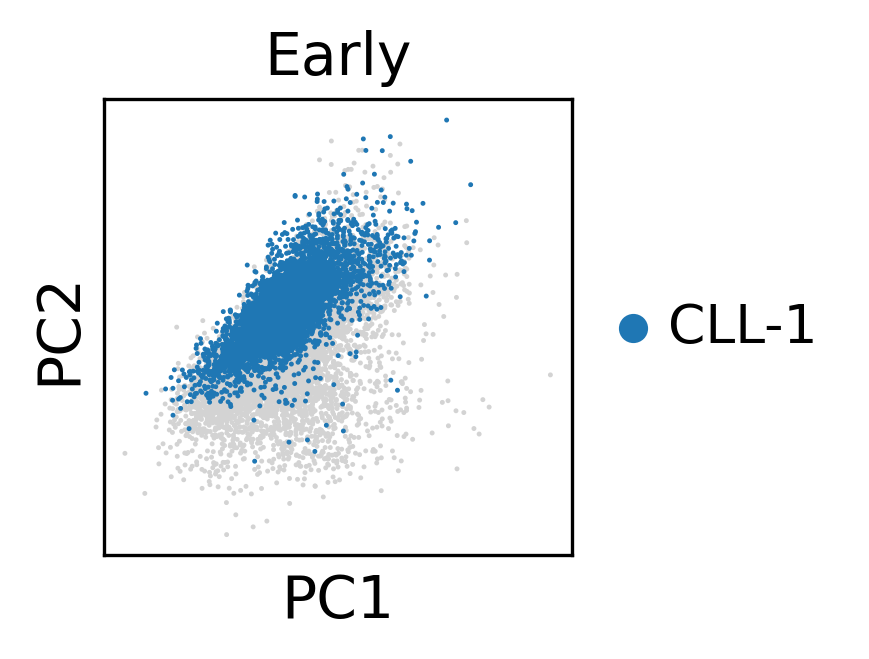

Trying to set attribute `.uns` of view, copying.


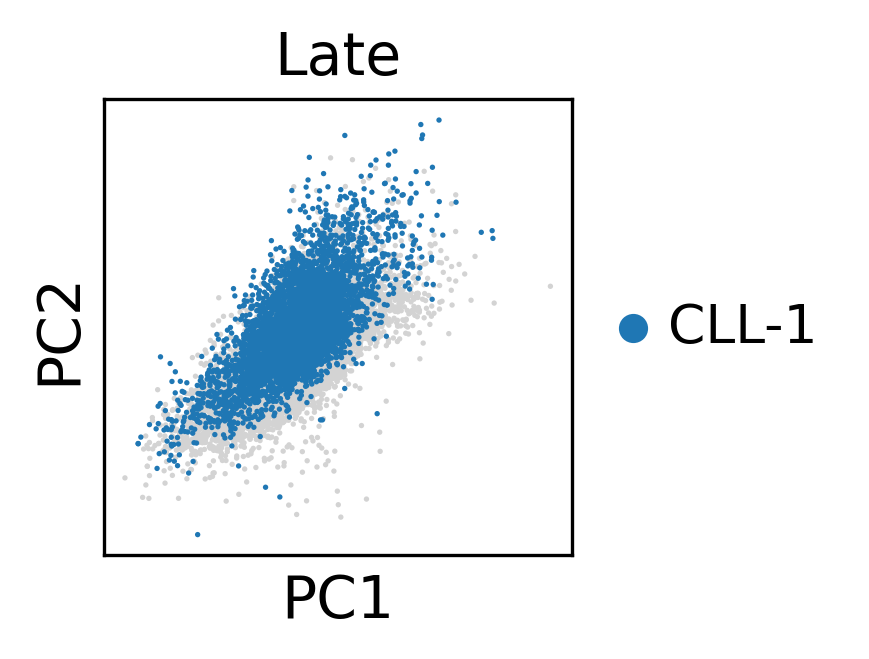

Trying to set attribute `.uns` of view, copying.


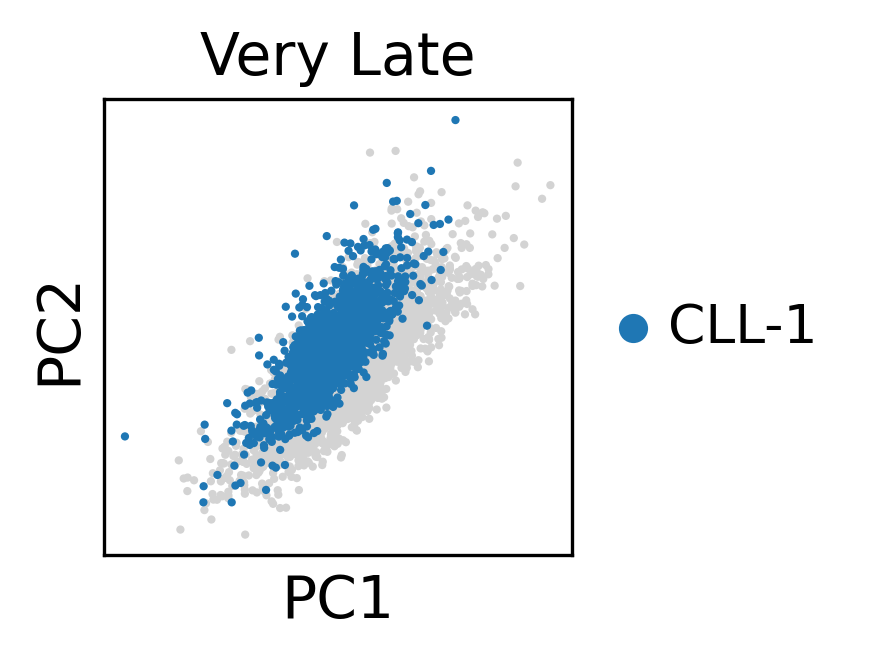

Trying to set attribute `.uns` of view, copying.


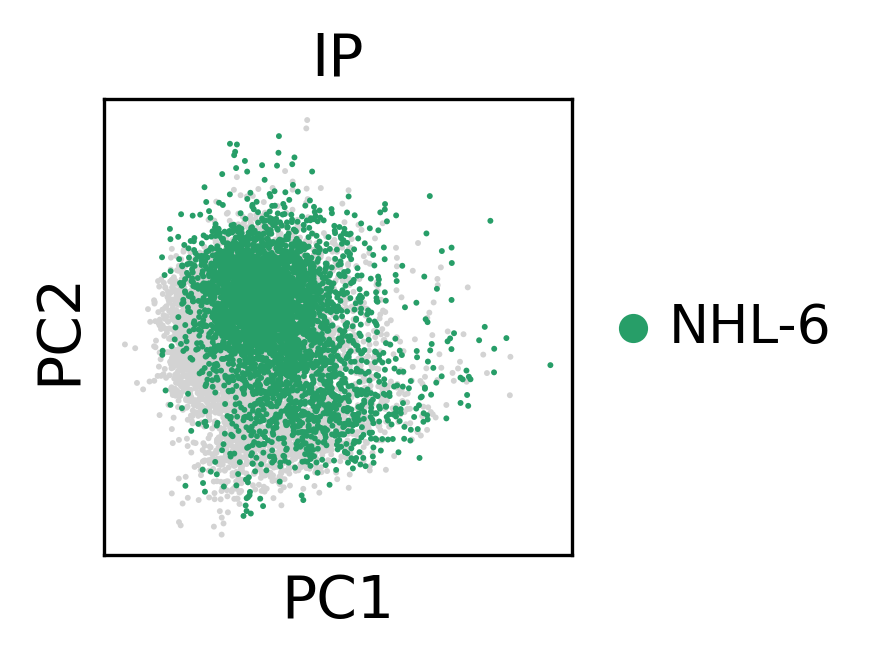

Trying to set attribute `.uns` of view, copying.


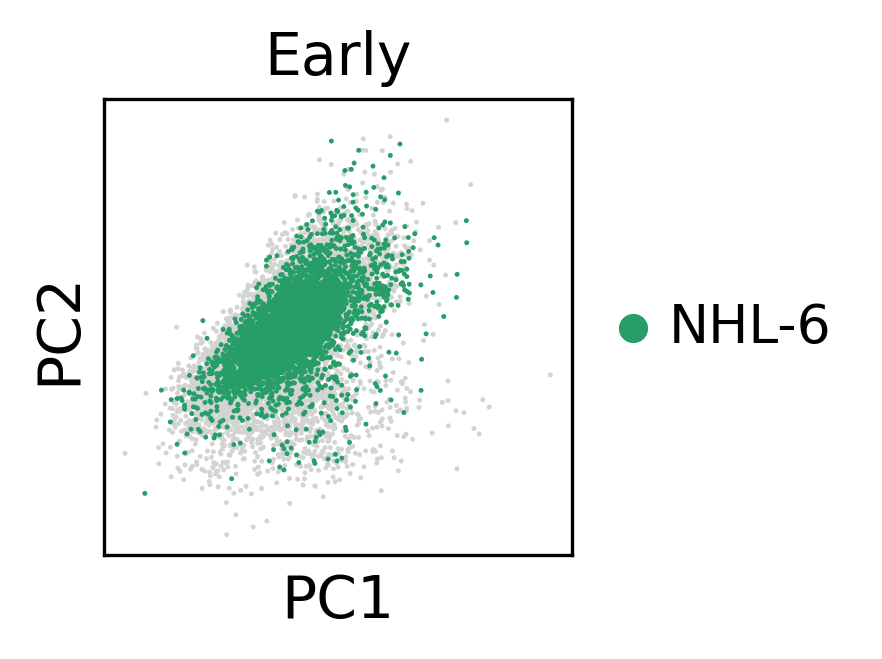

Trying to set attribute `.uns` of view, copying.


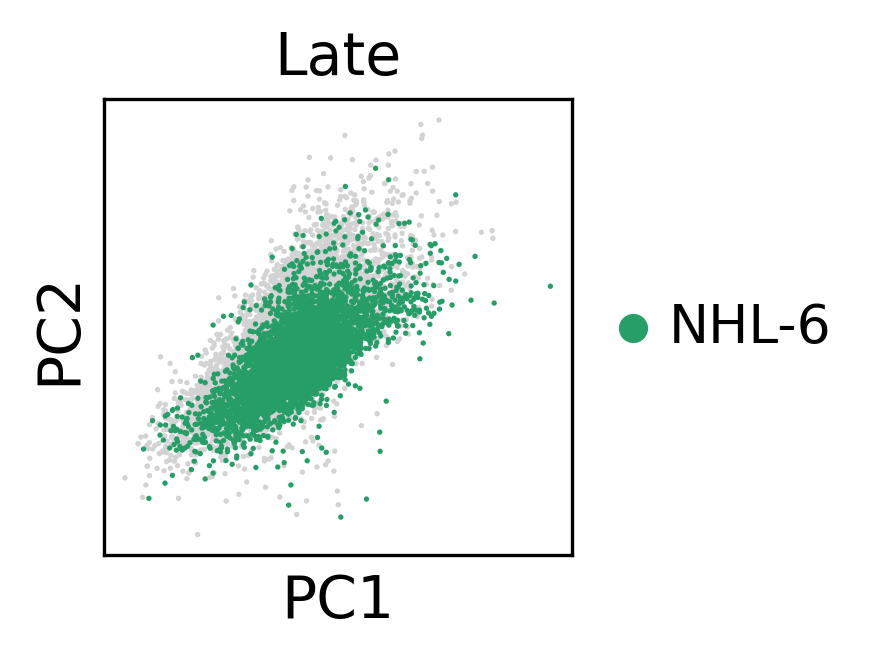

Trying to set attribute `.uns` of view, copying.


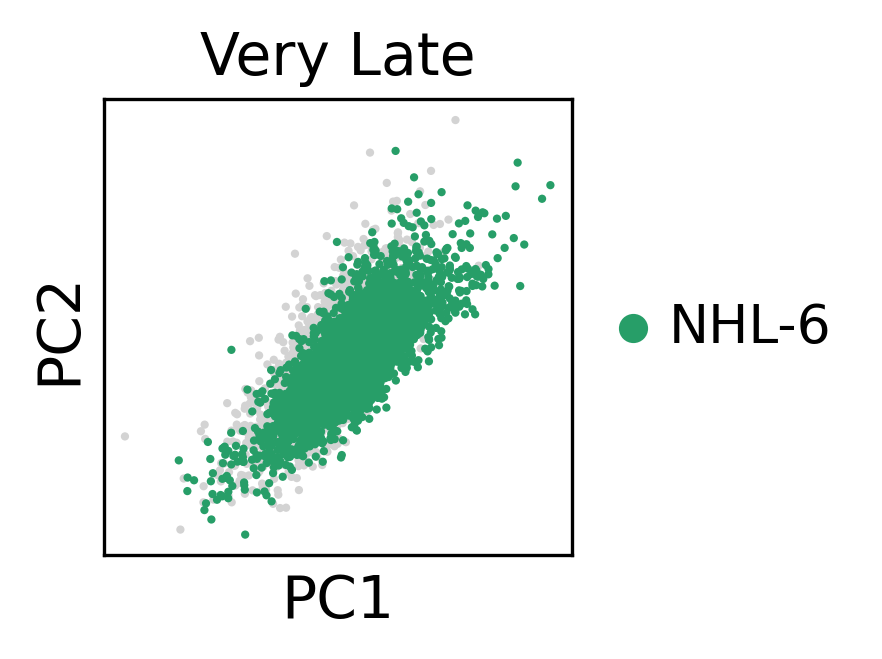

Trying to set attribute `.uns` of view, copying.


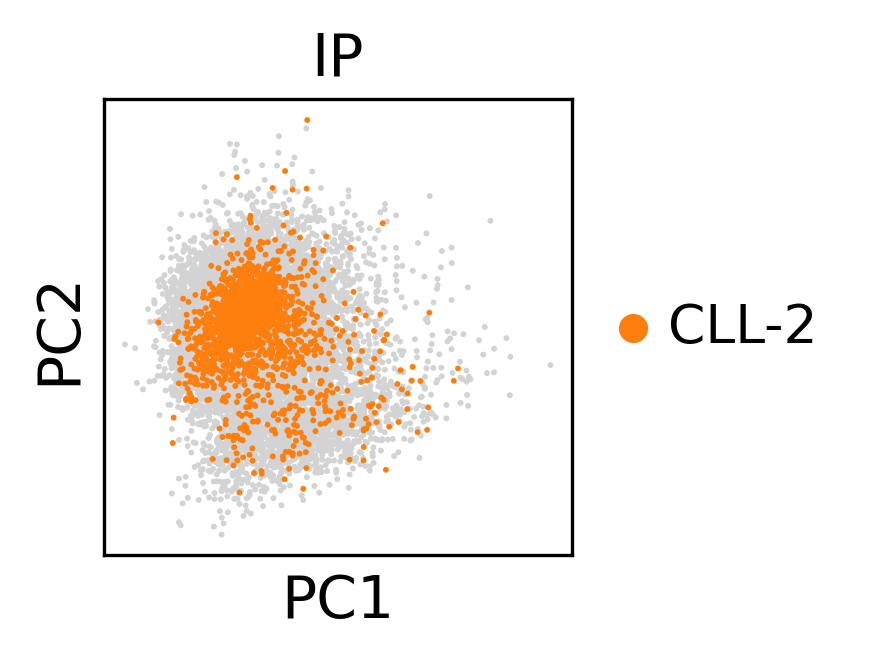

Trying to set attribute `.uns` of view, copying.


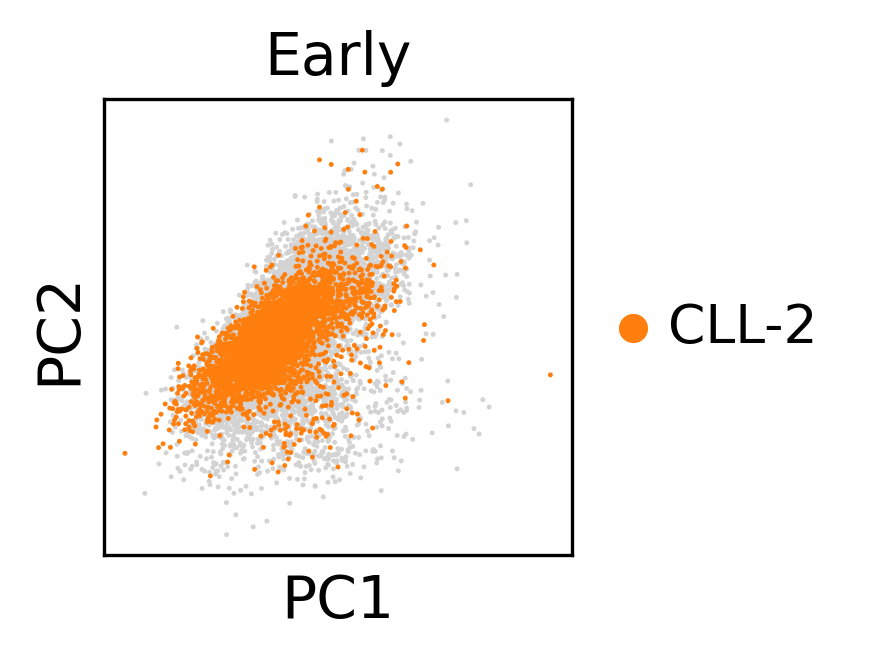

Trying to set attribute `.uns` of view, copying.


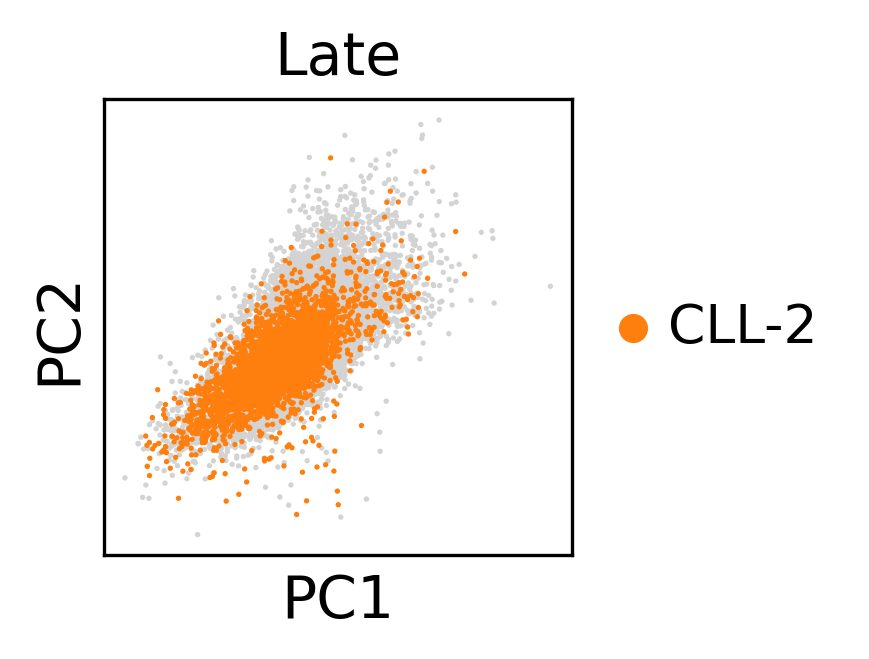

Trying to set attribute `.uns` of view, copying.


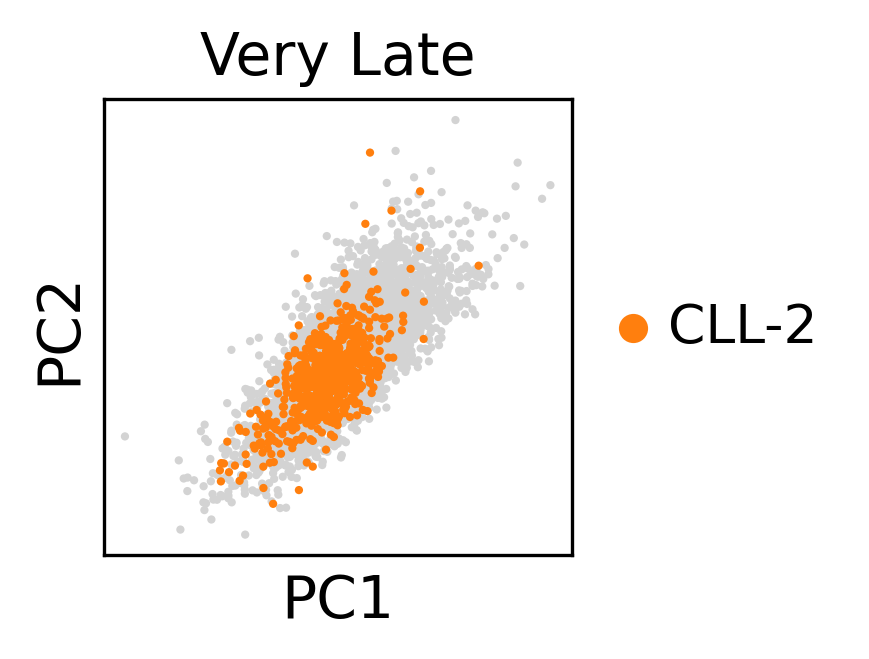

Trying to set attribute `.uns` of view, copying.


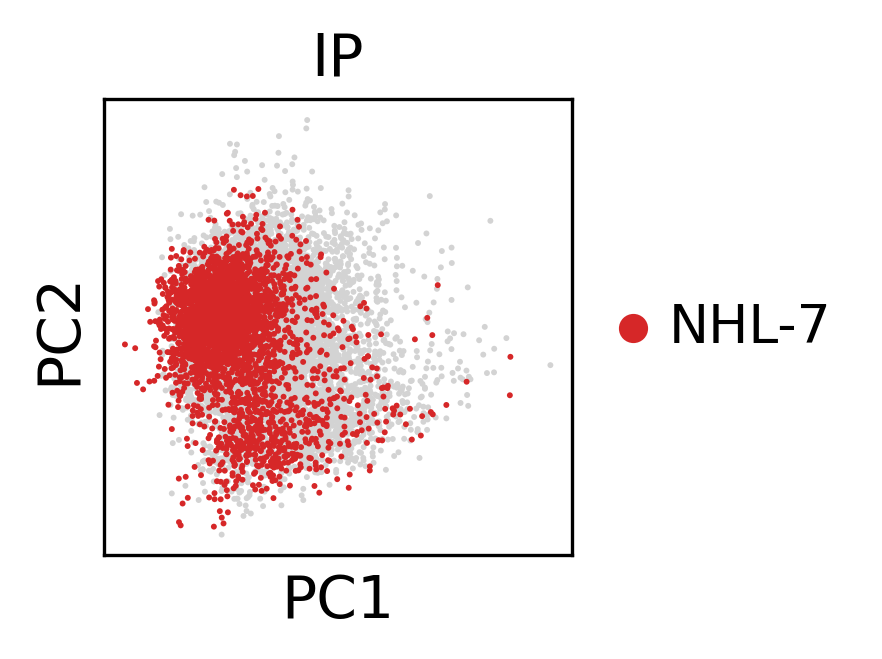

Trying to set attribute `.uns` of view, copying.


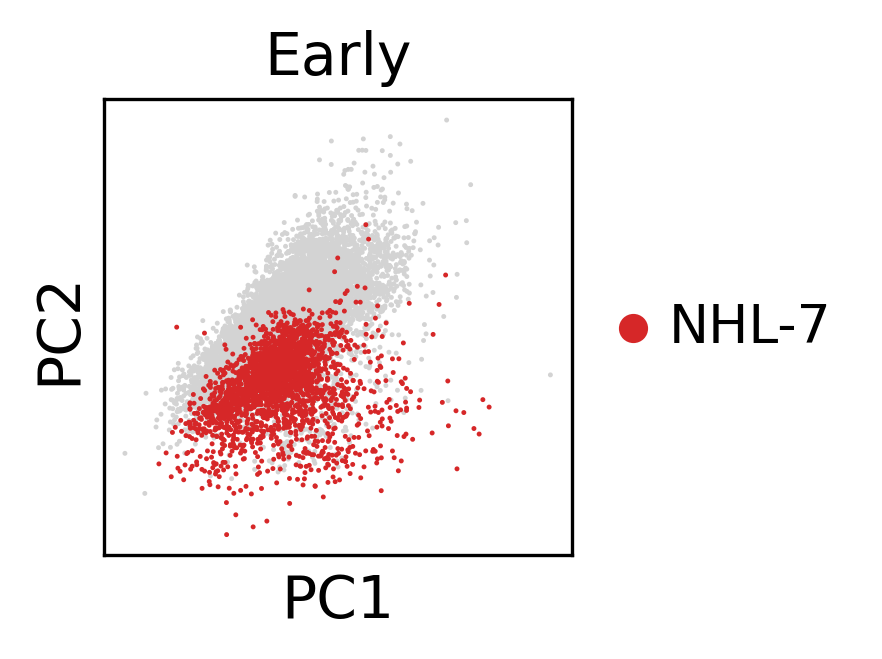

Trying to set attribute `.uns` of view, copying.


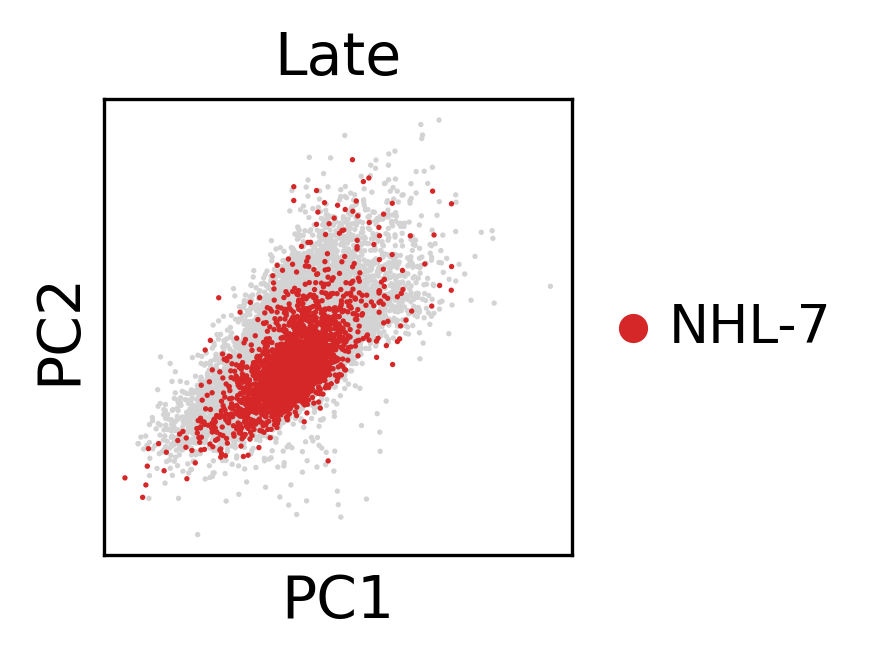

Trying to set attribute `.uns` of view, copying.


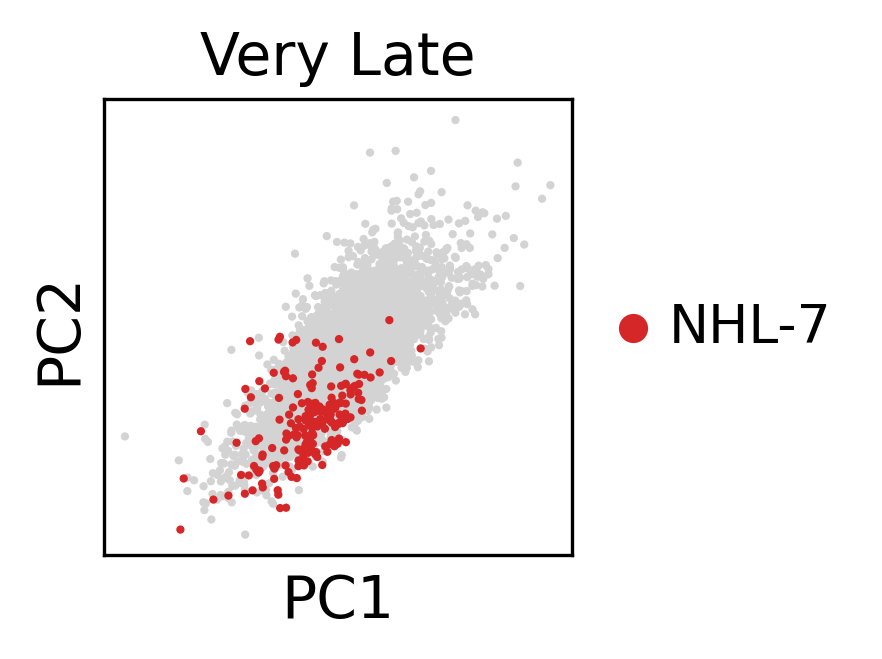

In [ ]:
# Figure 6A

# PCA plots of cell expression residuals (corrected data) from IP and blood at all time points
# Per patient and per time point / location
sc.settings.set_figure_params(dpi=150, figsize=(2,2))

# After regressing, which is similar to MAST filtering
# Potentially: Downsample data to account for differences in sample sizes between patients to achieve similar results to paper
for x in ge.obs.patient.unique():
  for y in ge.obs.group.unique():
    sc.pl.pca(ge[(ge.obs.group == y)], color=['patient'], groups=x,title=y, use_raw=False, ncols=4, wspace=0.1)

The patterns found in the PCA plots here, separated by patient and group (IP, Early, Late, Very Late) seem to be very similar; NHL-7 plots have the smallest area and NHL-6 and CLL-1 are prominent.

In [ ]:
# Work on Figure C: heatmap

In [ ]:
DEG_groups = pd.DataFrame(ge.uns['rank_genes_groups']['names'])
DEG_groups.head(25)

CLL-1_Early CLL-1_IP CLL-1_Late  ... NHL-7_IP NHL-7_Late NHL-7_Very Late
0        RPS26      LTB      RPS26  ...    GAPDH       GZMH           RPL41
1         GZMK     ENO1       CMC1  ...     TPI1     IFITM3          MT-ND4
2         CMC1      PKM     RPS4Y1  ...      MIF    MT-ATP6           RPL26
3         CD74     TPI1       PLS3  ...   MT-ND4       NKG7          RPL36A
4          MX1     LDHA      ASCL2  ...     LDHA     S100A4           RPS29
5         NKG7      MIF      KLRC1  ...      FOS      KLRG1           RPS26
6         IFI6   RPS4Y1      DUSP2  ...    ALDOA     FCGR3A          PMAIP1
7        ISG15      GPI  MTRNR2L12  ...   SLC2A3   HLA-DRB1          NFKBIA
8         PRF1    GAPDH     RPL36A  ...    TIMP1       FLNA         MT-ATP6
9         XAF1     PGK1       LYST  ...  S100A11   HLA-DRB5         TSC22D3
10       ISG20      JUN    MT-ATP6  ...      GPI      RPL26          IFITM3
11      RPS4Y1    ALDOA       PRF1  ...     ENO1     ADGRG1         TNFAIP3
12        CST7     IER2   HLA-DQB1  ...      JUN     MT-ND4            FTH1
13      IFITM1  SLC16A3     FAM65B  ...   IFITM3       XIST           CXCR4
14        LAG3    RPS26       CST7  ...  MT-ND4L      TXNIP             FTL
15      TRIM22    LRRN3      DDX17  ...     PGK1   HLA-DQA2          MT-CYB
16       NR4A2     CISH      CADM1  ...     IL32     S100A6            OASL
17       DUSP2     RBPJ     TRIM22  ...      VIM      S1PR5          DNAJB6
18     EIF2AK2    EGLN3      IKZF3  ...  S100A10       GZMB           PELI1
19       ARL4C     HOPX     RNF213  ...      PKM       SRRT           HIF1A
20        PLS3    TIMP1      ARL4C  ...     EGR1      RPL41            CCL3
21       STAT1   IFITM2      P2RY8  ...  ALOX5AP     RPL36A           IFIT2
22      RNF213     IL32     RALGDS  ...     IER2      RPS29          MT-ND3
23        ADAR    BNIP3     MT-ND5  ...    ACTG1      RPS26           NR4A2
24        MT2A   MT-ND4      RPL26  ...    GATA3       KLF2          S100A4

[25 rows x 16 columns]

In [ ]:
result = ge.uns['rank_genes_groups']
gene_g = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in gene_g for key in ['names']}).head()

CLL-1_Early_n CLL-1_IP_n  ... NHL-7_Late_n NHL-7_Very Late_n
0         RPS26        LTB  ...         GZMH             RPL41
1          GZMK       ENO1  ...       IFITM3            MT-ND4
2          CMC1        PKM  ...      MT-ATP6             RPL26
3          CD74       TPI1  ...         NKG7            RPL36A
4           MX1       LDHA  ...       S100A4             RPS29

[5 rows x 16 columns]

In [ ]:
ge.uns['rank_genes_groups']['pvals']

rec.array([(0., 0., 0.00000000e+000, 0.00000000e+000, 0., 0., 0., 7.36962637e-221, 0., 0., 0., 0., 0., 0., 3.57624426e-294, 1.59966849e-68),
           (0., 0., 0.00000000e+000, 1.27685570e-270, 0., 0., 0., 7.14753917e-215, 0., 0., 0., 0., 0., 0., 1.62663561e-279, 1.99401032e-48),
           (0., 0., 1.06076042e-234, 8.16016438e-264, 0., 0., 0., 1.00837675e-181, 0., 0., 0., 0., 0., 0., 9.38495899e-276, 1.21414406e-47),
           ...,
           (0., 0., 0.00000000e+000, 0.00000000e+000, 0., 0., 0., 0.00000000e+000, 0., 0., 0., 0., 0., 0., 0.00000000e+000, 0.00000000e+00),
           (0., 0., 0.00000000e+000, 0.00000000e+000, 0., 0., 0., 0.00000000e+000, 0., 0., 0., 0., 0., 0., 0.00000000e+000, 0.00000000e+00),
           (0., 0., 0.00000000e+000, 0.00000000e+000, 0., 0., 0., 0.00000000e+000, 0., 0., 0., 0., 0., 0., 0.00000000e+000, 0.00000000e+00)],
          dtype=[('CLL-1_Early', '<f8'), ('CLL-1_IP', '<f8'), ('CLL-1_Late', '<f8'), ('CLL-1_Very Late', '<f8'), ('CLL-2_Early', '<f8'), 

In [ ]:
#Copy the top 200 genes from top_rank genes into a new dataframe
#only keep those genes that have logFC = 1.5
#only keep the genes with FDR or adjusted p_vals < 0.05
top_gene_lfc = DEG_groups.head(300).copy()

for x in top_gene_lfc.columns:
  for y in top_gene_lfc.index:
    if ge.uns['rank_genes_groups']['logfoldchanges'][y][x] < 1.5:
      top_gene_lfc[x][y] = 'nan'
    if ge.uns['rank_genes_groups']['pvals_adj'][y][x] > 0.05:
      top_gene_lfc[x][y] = 'nan'

top_gene_lfc

CLL-1_Early  CLL-1_IP CLL-1_Late  ...  NHL-7_IP NHL-7_Late NHL-7_Very Late
0         RPS26       LTB      RPS26  ...     GAPDH       GZMH           RPL41
1          GZMK      ENO1       CMC1  ...      TPI1     IFITM3          MT-ND4
2          CMC1       PKM     RPS4Y1  ...       MIF    MT-ATP6           RPL26
3          CD74      TPI1       PLS3  ...    MT-ND4       NKG7          RPL36A
4           MX1      LDHA      ASCL2  ...      LDHA     S100A4           RPS29
..          ...       ...        ...  ...       ...        ...             ...
295       PATL2     LTB4R      TRGV3  ...  ARHGAP35      BACH1             nan
296       USP9Y  TRAV26-1     CAPN15  ...       FTX    NCR3LG1             nan
297   HIST1H2AB     SETD6      JADE2  ...      RGP1    HNRNPH1             nan
298      NOTCH1      XPO5      NUMA1  ...  MAPK8IP1      KIF22             nan
299        H1FX      RHOB      TTC14  ...   HLA-DRA     IQSEC1             nan

[300 rows x 16 columns]

In [ ]:
ge.uns['rank_genes_groups']['logfoldchanges'].field(2)[:50]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)

In [ ]:
ge.uns['rank_genes_groups']['scores'].field(2)[:100]

array([47.67637 , 41.5159  , 34.113647, 28.786495, 28.096004, 26.656298,
       26.58292 , 26.39014 , 23.961533, 23.606647, 23.331198, 23.069395,
       22.852343, 22.573029, 22.39614 , 22.132683, 21.968391, 20.862661,
       20.713   , 20.223162, 19.742167, 18.736362, 18.241083, 17.547558,
       17.506031, 16.903225, 16.887648, 16.5108  , 16.510662, 16.447521,
       16.341135, 16.28135 , 16.114206, 16.099606, 16.028894, 15.977135,
       15.537551, 15.392263, 15.049597, 14.920359, 14.900084, 14.895105,
       14.785445, 14.640897, 14.463626, 14.38057 , 14.249587, 14.125401,
       14.092034, 14.016567, 13.979701, 13.788758, 13.678141, 13.675679,
       13.622405, 13.611538, 13.532215, 13.460462, 12.913408, 12.898264,
       12.769651, 12.722209, 12.604177, 12.556505, 12.555225, 12.420944,
       12.211523, 12.190748, 12.148011, 12.122321, 12.120526, 12.021267,
       12.021233, 11.937925, 11.935444, 11.848277, 11.818941, 11.512882,
       11.505902, 11.459173, 11.441266, 11.431079, 

In [ ]:
# From the genes in top_gene_lfc only keep those genes that are differentially 
# expressed between clusters in all four patients

heat_genes = []

for x in top_gene_lfc['CLL-1_IP']:
  if (top_gene_lfc['CLL-2_IP'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_IP'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_IP'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Early']:
  if (top_gene_lfc['CLL-2_Early'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Early'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Early'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Late']:
  if (top_gene_lfc['CLL-2_Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Late'].str.contains(x)).sum() == 3:
    heat_genes.append(x)
for x in top_gene_lfc['CLL-1_Very Late']:
  if (top_gene_lfc['CLL-2_Very Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-6_Very Late'].str.contains(x)).sum()+(top_gene_lfc['NHL-7_Very Late'].str.contains(x)).sum() == 3:
    heat_genes.append(x)

heat_genes
   

['ENO1',
 'PKM',
 'TPI1',
 'LDHA',
 'MIF',
 'GPI',
 'GAPDH',
 'PGK1',
 'ALDOA',
 'IER2',
 'SLC16A3',
 'CISH',
 'RBPJ',
 'EGLN3',
 'HOPX',
 'TIMP1',
 'IL32',
 'BNIP3',
 'EGR1',
 'VIM',
 'CD69',
 'SLC2A3',
 'DDIT4',
 'FOSB',
 'TNFSF10',
 'IL2RA',
 'FTL',
 'RP11-160E2.6',
 'LGALS3',
 'DUSP6',
 'FOXP3',
 'ITM2C',
 'ALOX5AP',
 'TC2N',
 'PHLDA1',
 'IL7R',
 'BTG2',
 'S100A11',
 'SORL1',
 'JUNB',
 'H2AFZ',
 'AQP3',
 'MAL',
 'CD7',
 'CH17-373J23.1',
 'RNU12',
 'ZNF292',
 'USP22',
 'TUBB',
 'HILPDA',
 'WSB1',
 'KLF6',
 'STX16',
 'ITGA5',
 'SYTL2',
 'ATP8B4',
 'SPG11',
 'YEATS2',
 'USP20',
 'TPM4',
 'RP11-325F22.2',
 'C5orf45',
 'H1F0',
 'DNASE1',
 'HELB',
 'STAT4',
 'ZEB1',
 'ALAS1',
 'ZFP30',
 'GOLGA8A',
 'KDM7A',
 'HIPK2',
 'ZDBF2',
 'GZMK',
 'CD74',
 'NKG7',
 'MT2A',
 'CCL4',
 'CBLB',
 'RGS1',
 'UCP2',
 'GZMB',
 'GBP5',
 'FLNA',
 'RNF19A',
 'GZMA',
 'MYH9',
 'MTSS1',
 'TNFAIP3',
 'NFKBIA',
 'PFN1',
 'REL',
 'PRR5',
 'ASCL2',
 'MT-ATP6',
 'PRF1',
 'CST7',
 'IKZF3',
 'P2RY8',
 'MT-ND5',
 'TTC38

In [ ]:
# Sort values to only include IP
ge_IP = ge[ge.obs['group'] == 'IP', :]

In [ ]:
ge_IP.obs.head(10)

sample_id patient time_point  ... n_genes n_counts leiden
AAACCTGAGCGTCTAT-1         1   CLL-1         IP  ...    2500   8780.0      0
AAACCTGCAATAGAGT-1         1   CLL-1         IP  ...    2549   8782.0      0
AAACCTGCATGACGGA-1         1   CLL-1         IP  ...    3146  10911.0      9
AAACCTGGTAGTGAAT-1         1   CLL-1         IP  ...    4310  18042.0      9
AAACCTGGTCTCCCTA-1         1   CLL-1         IP  ...    4628  24558.0      9
AAACCTGTCAAGAAGT-1         1   CLL-1         IP  ...    2033   5309.0      9
AAACCTGTCATTGCGA-1         1   CLL-1         IP  ...    4048  16455.0      0
AAACCTGTCCCACTTG-1         1   CLL-1         IP  ...    2352   7815.0      0
AAACCTGTCCTTTACA-1         1   CLL-1         IP  ...    3692  13975.0      0
AAACGGGCACGTAAGG-1         1   CLL-1         IP  ...    1135   2486.0      0

[10 rows x 10 columns]

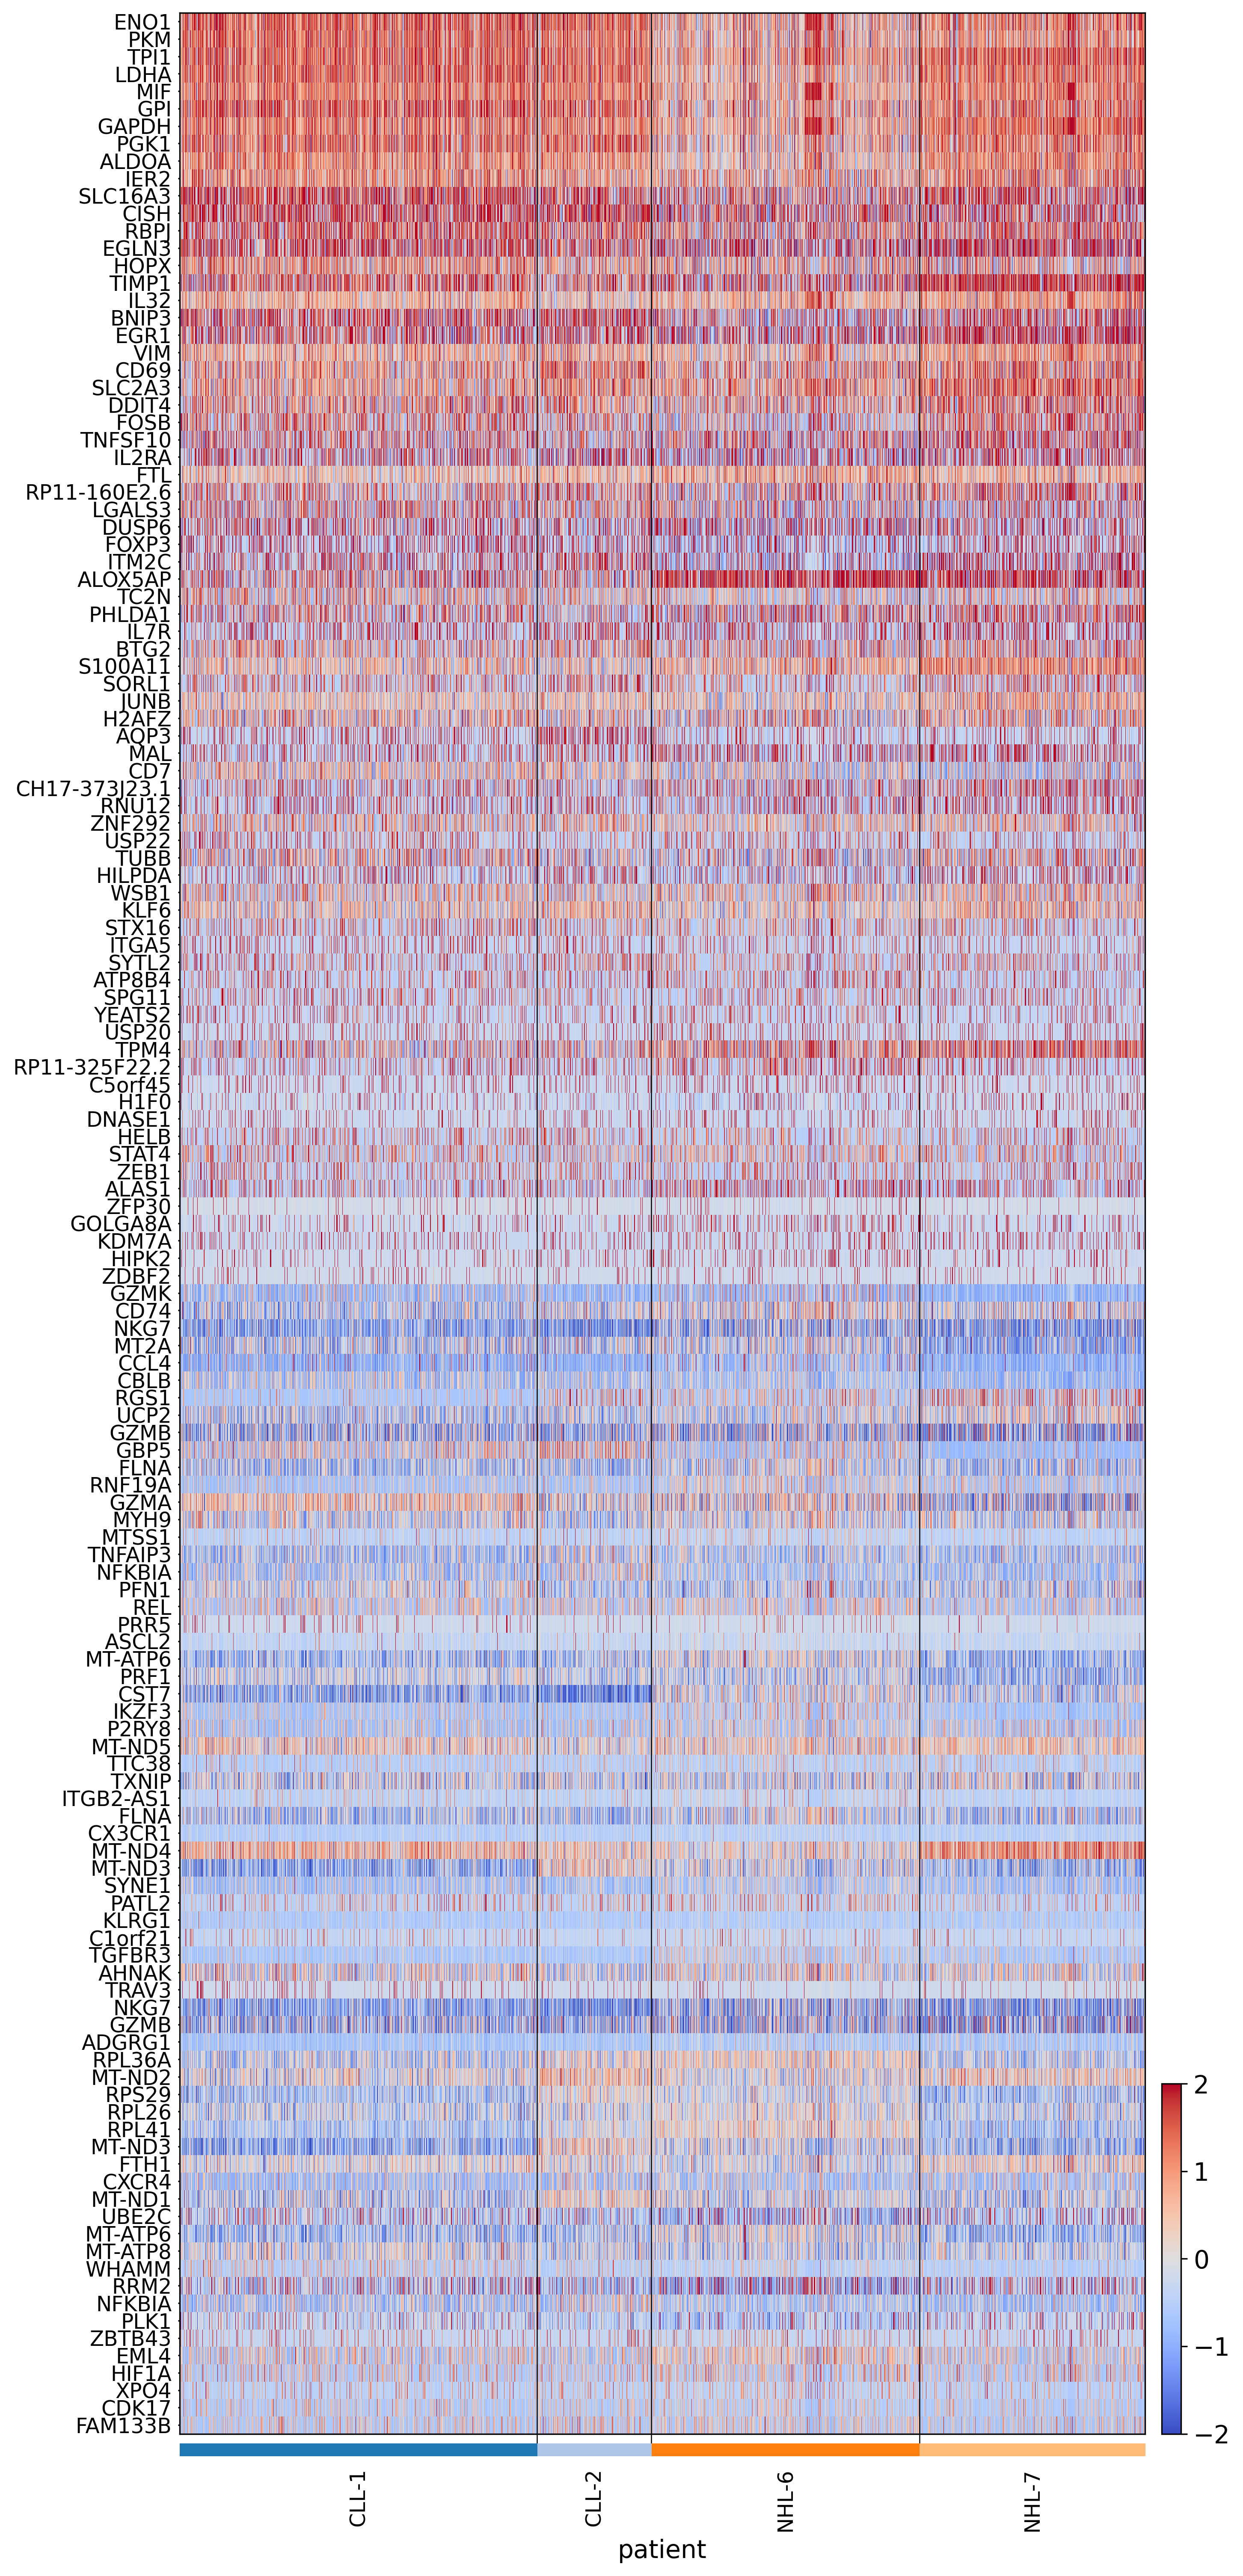

In [ ]:
# Figure 6B

#Plot the expression values of genes found in IP
sc.pl.heatmap(ge_IP, groupby='patient', var_names=heat_genes, swap_axes=True, 
              vmin =-2, vmax=2, dendrogram=False, use_raw=False, show_gene_labels=True, cmap='coolwarm')

In [ ]:
ge_test = ge[ge.obs['group'] == 'IP', :]

In [ ]:
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

The patterns found in the PCA plots here, separated by patient and group (IP, Early, Late, Very Late) seem to be very similar; NHL-7 plots have the smallest area and NHL-6 and CLL-1 are prominent. 

In [ ]:
# Start work on Figure B

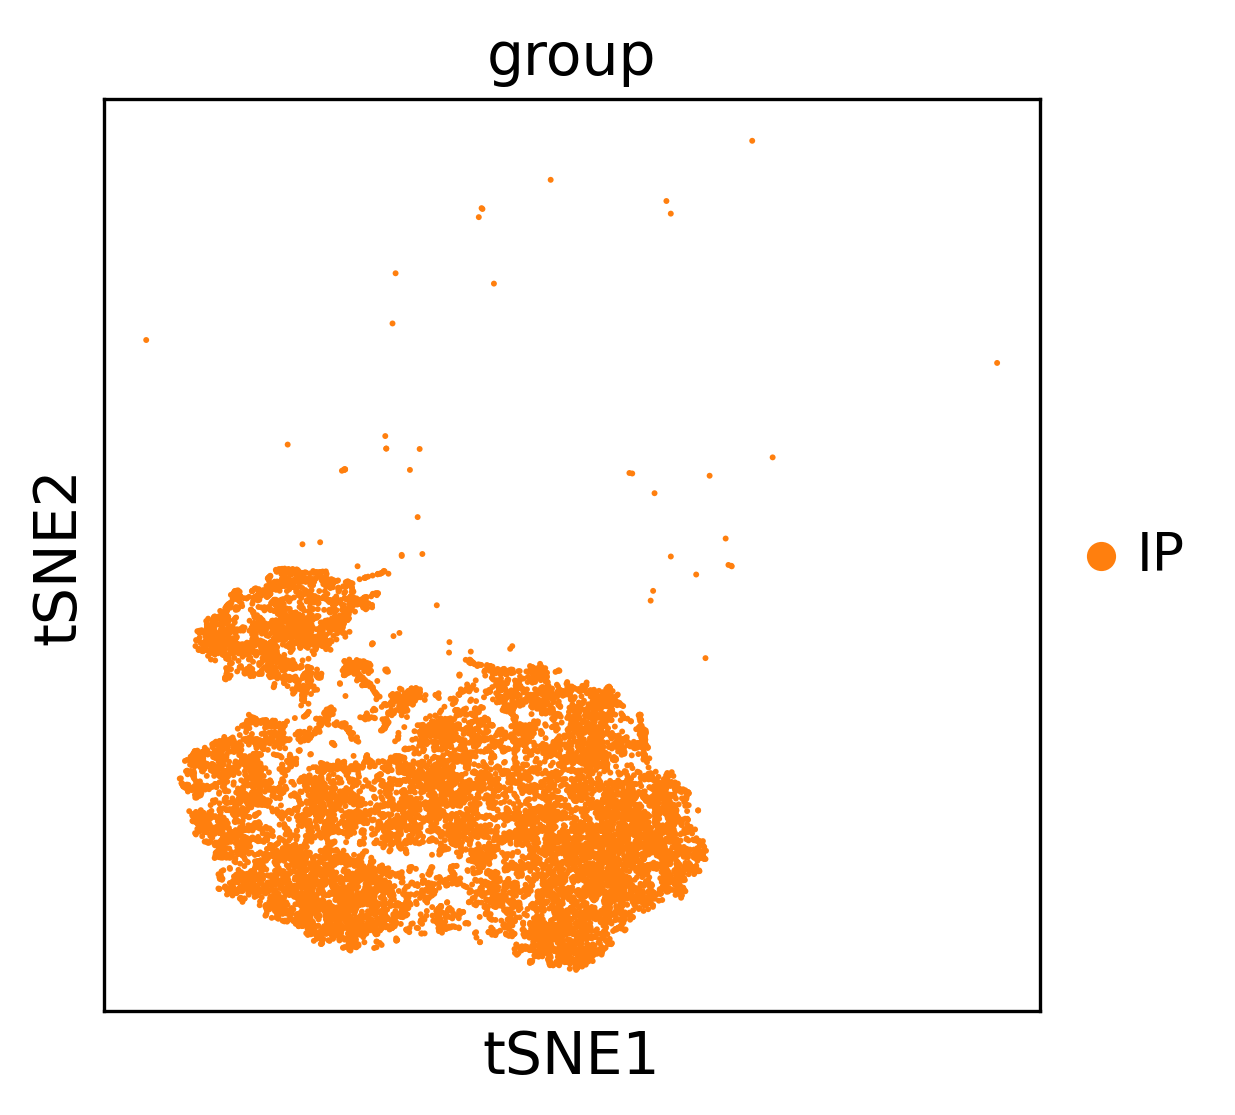

Trying to set attribute `.uns` of view, copying.


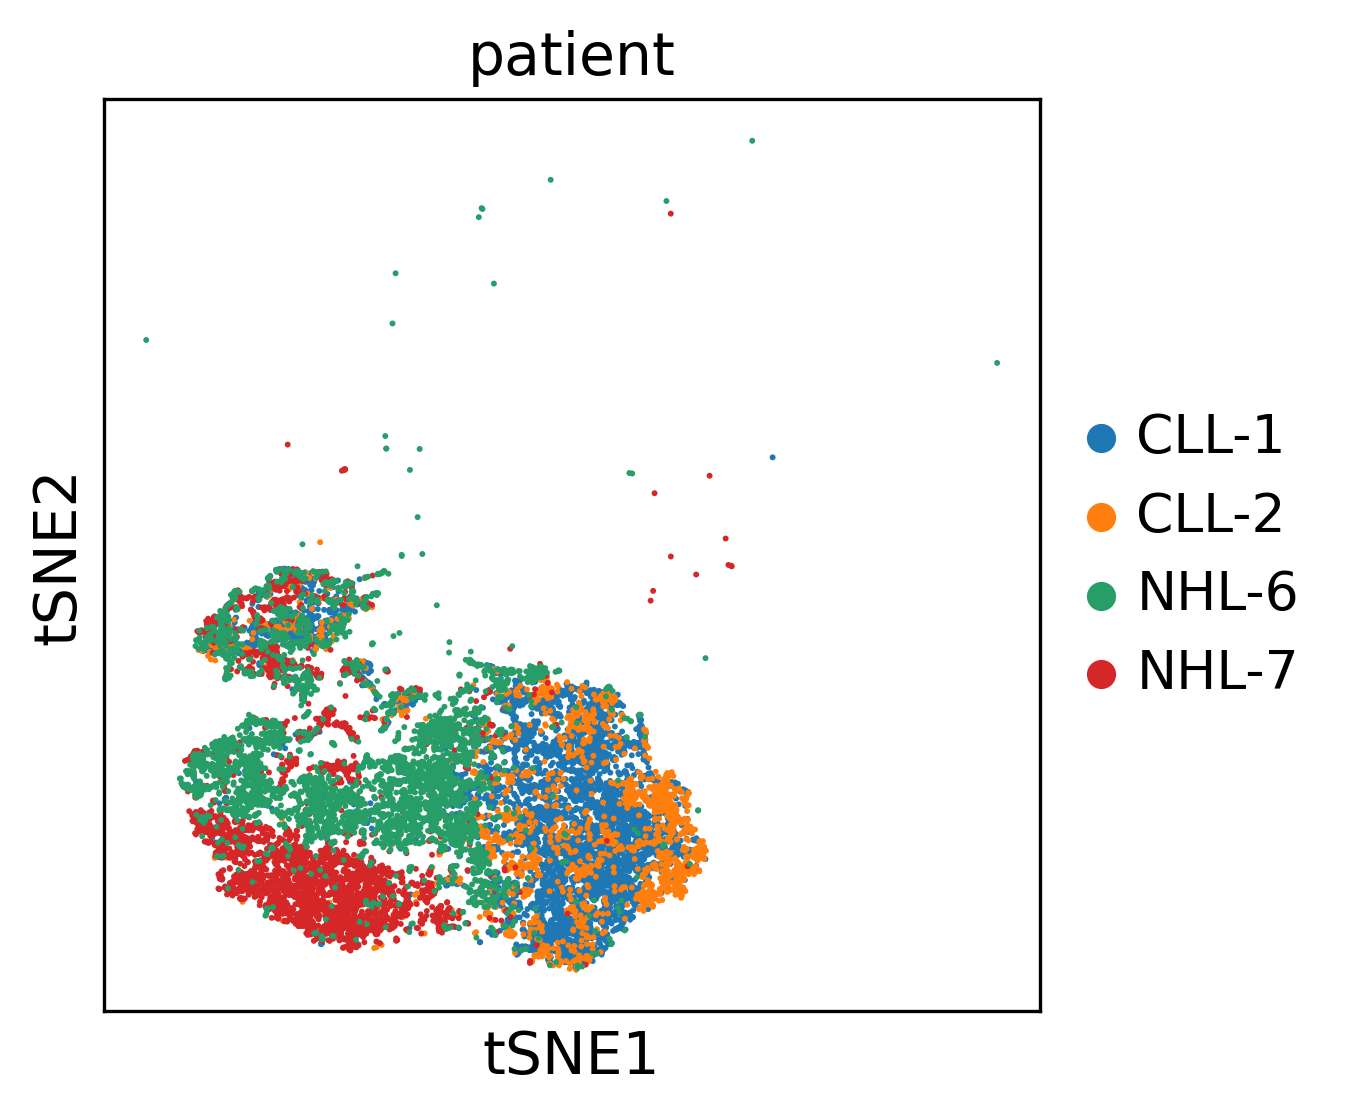

In [ ]:
# Understanding the location and boundaries of the IP section of tsne plot
# Understanding the distribution of patients in the IP
sc.settings.set_figure_params(dpi=150)

sc.pl.tsne(ge[(ge.obs.group == 'IP'), :], color=['group'], use_raw=False)
sc.pl.tsne(ge[(ge.obs.group == "IP"), :], color=['patient'], use_raw=False)

In [ ]:
ge[(ge.obs.group == 'IP'), :]

View of AnnData object with n_obs × n_vars = 14896 × 2685
    obs: 'sample_id', 'patient', 'time_point', 'group', 'patient_point', 'disease', 'percent_mito', 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'group_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
# Isolate the IP in order to implement clustering algorithm
ge_test = ge[ge.obs['group'] == 'IP', :]

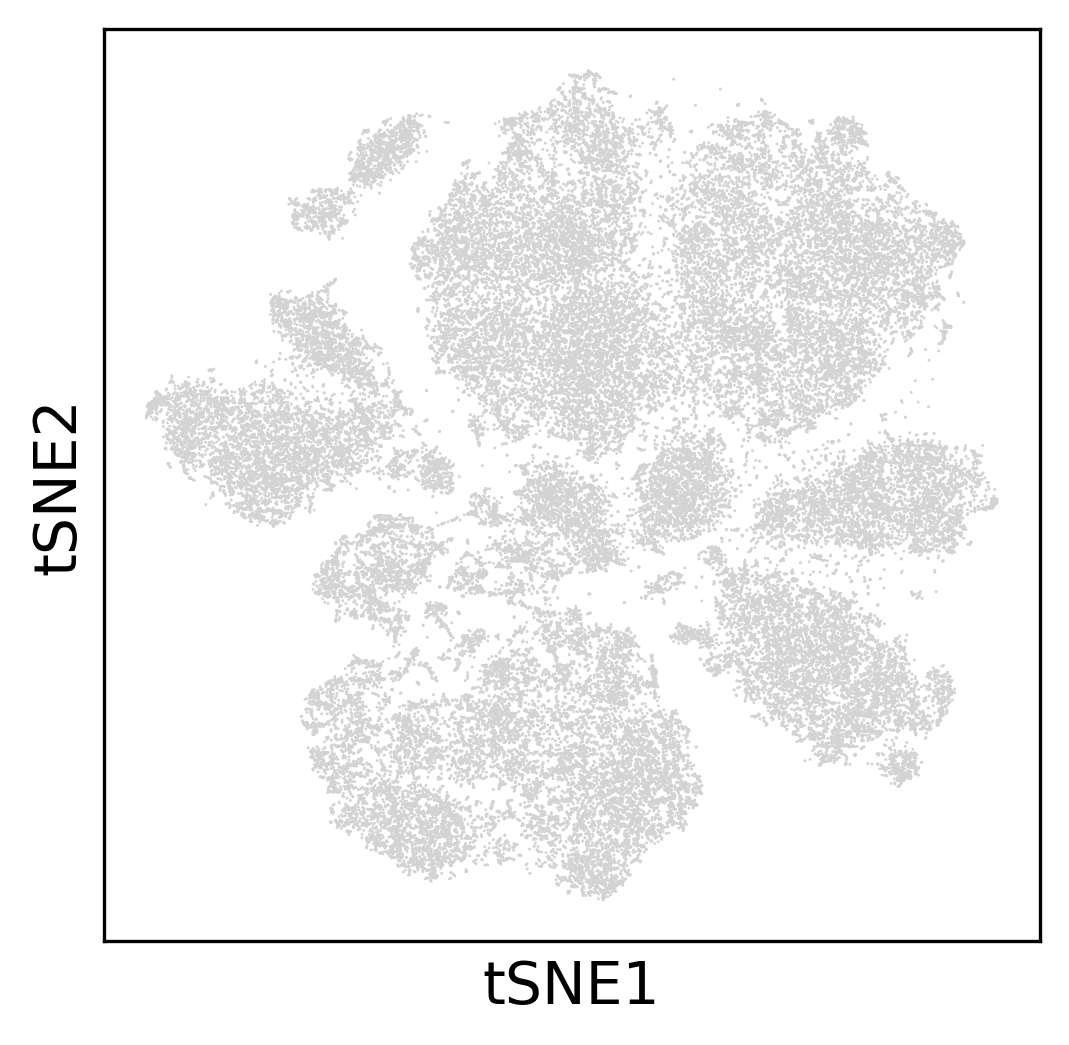

In [ ]:
sc.pl.tsne(ge)

Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'kmeans4' as categorical


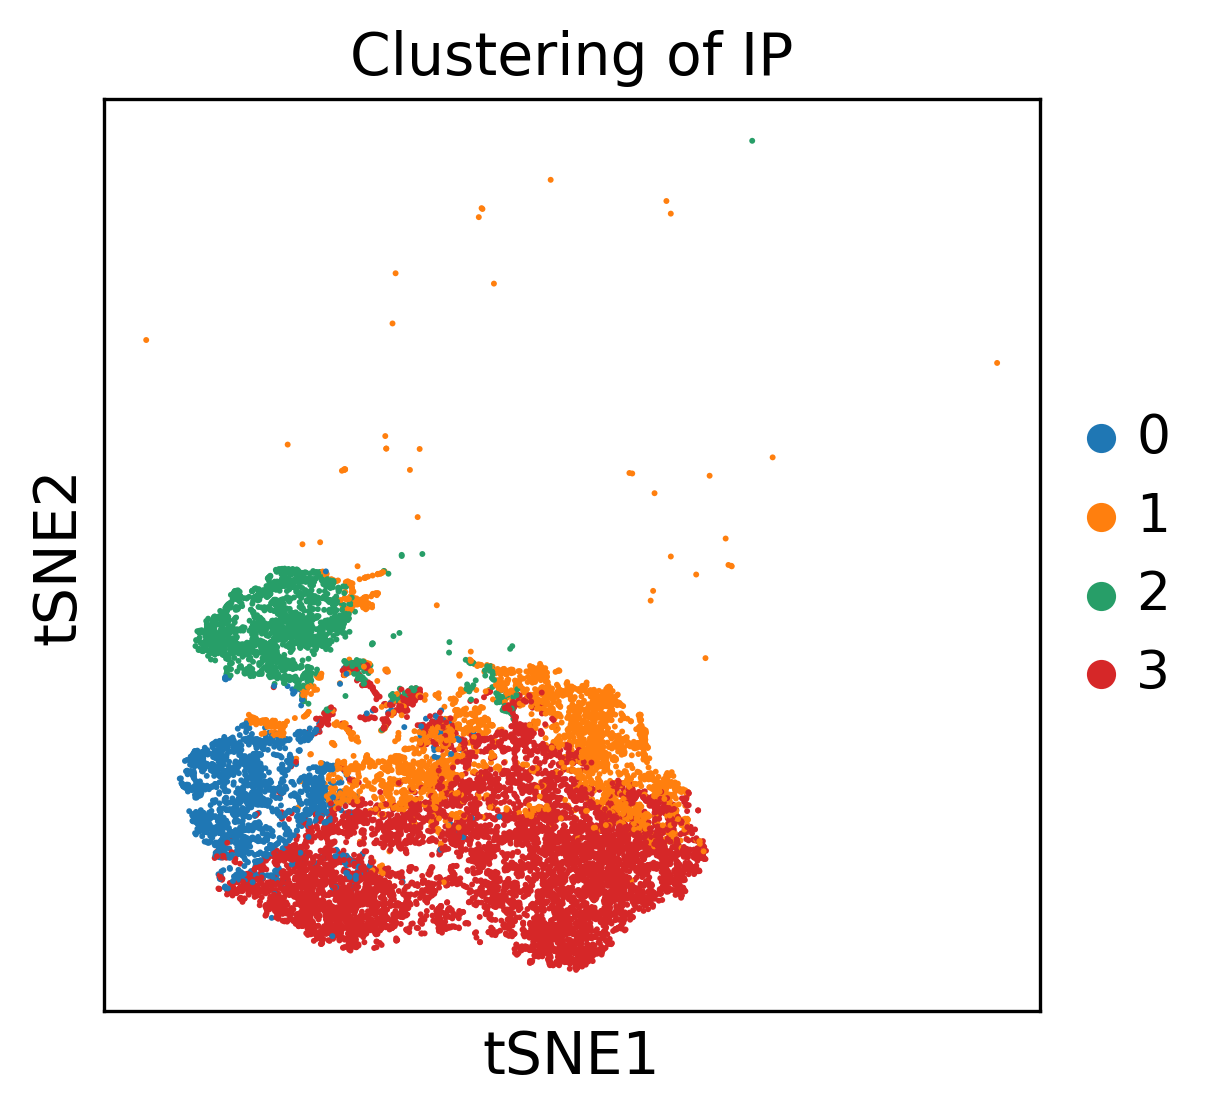

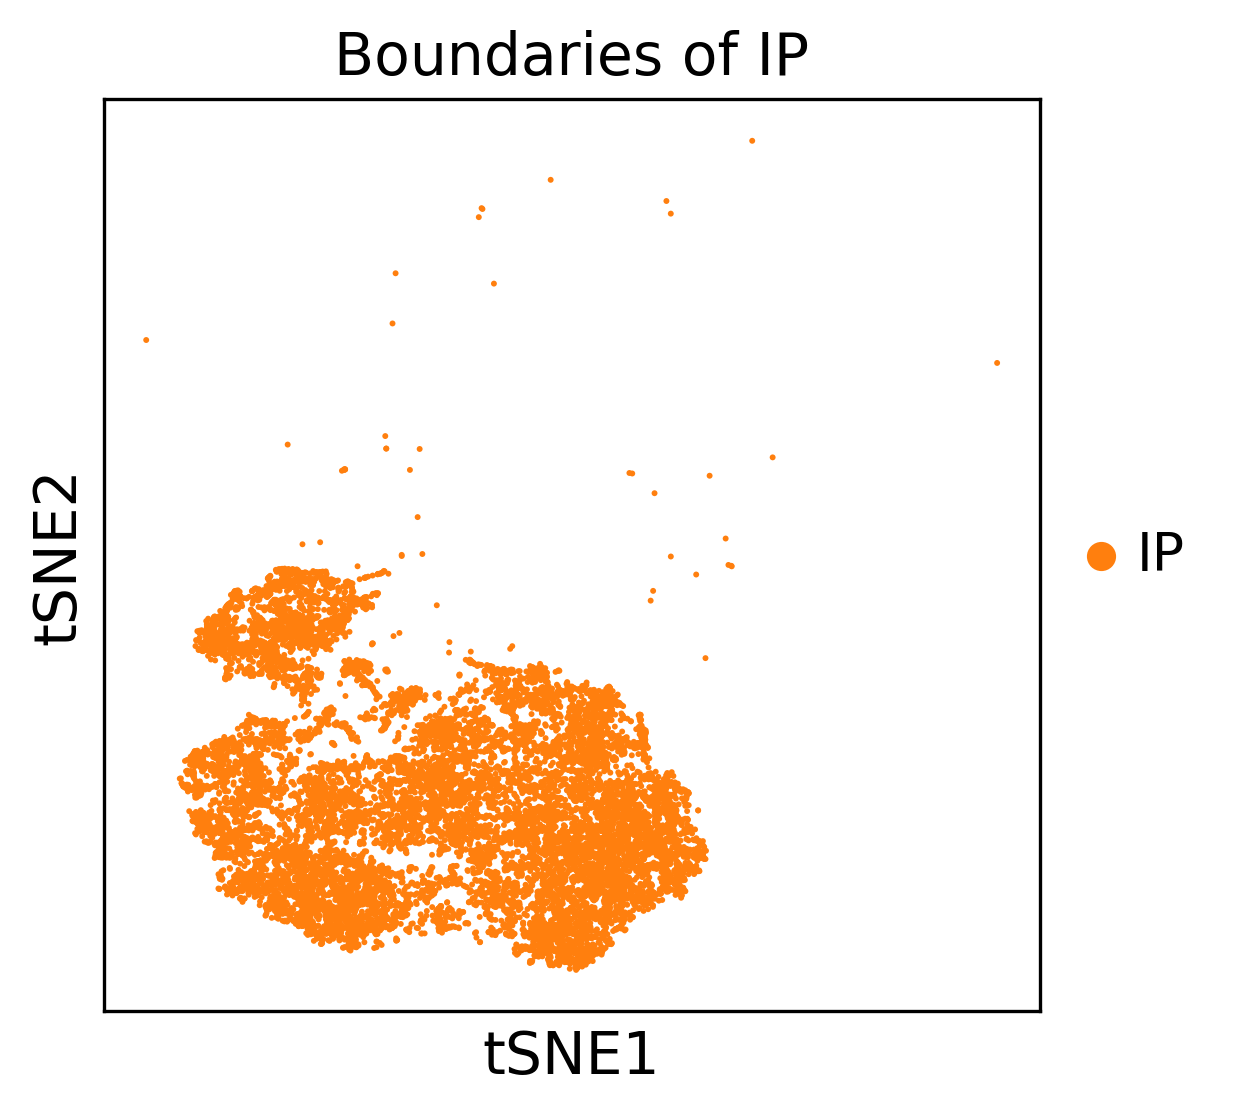

Trying to set attribute `.uns` of view, copying.


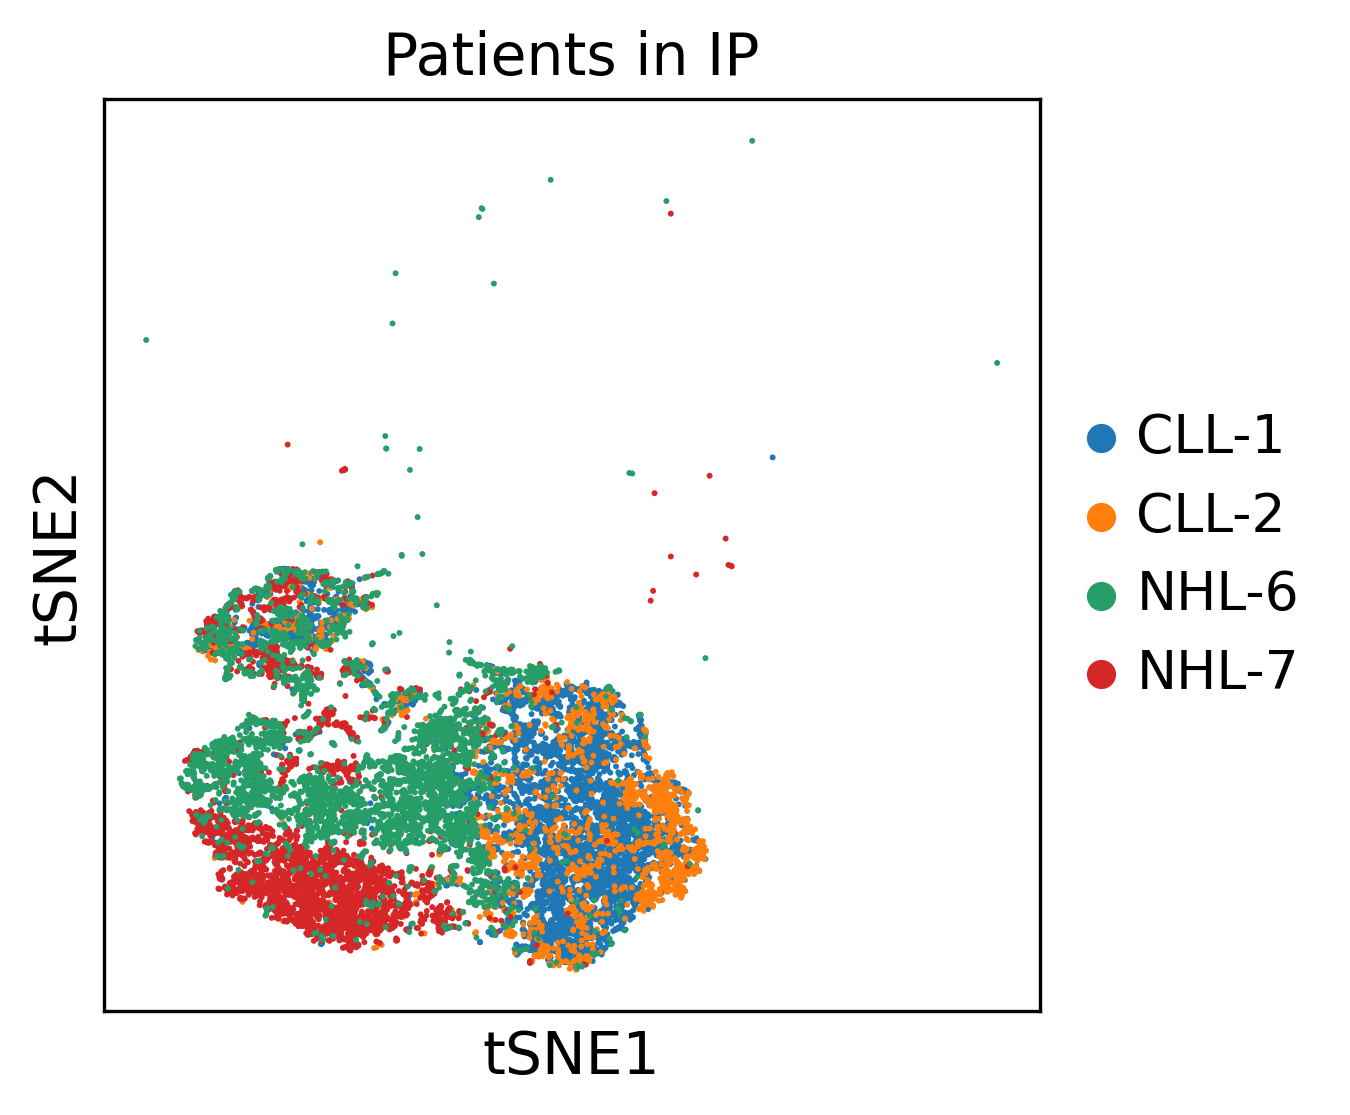

In [ ]:
# Figure C: Utilize unsupervised clustering in a t-SNE plot to highlight the four clusters in IP cells only

# Generate 4 clusters within the IP section
X_pca = ge_test.obsm['X_pca']

kmeans = KMeans(n_clusters=4, random_state=0, n_init=100).fit(X_pca)
ge_test.obs['kmeans4'] = kmeans.labels_.astype(list)

sc.pl.tsne(ge_test[ge_test.obs.group == 'IP', :], color=['kmeans4'], title='Clustering of IP')
sc.pl.tsne(ge[(ge.obs.group == 'IP'), :], color=['group'], use_raw=False, title='Boundaries of IP')
sc.pl.tsne(ge[(ge.obs.group == "IP"), :], color=['patient'], use_raw=False, title='Patients in IP')

In [ ]:
ge_test.obs.head()

sample_id patient time_point  ... n_counts leiden kmeans4
AAACCTGAGCGTCTAT-1         1   CLL-1         IP  ...   8780.0      0       1
AAACCTGCAATAGAGT-1         1   CLL-1         IP  ...   8782.0      0       1
AAACCTGCATGACGGA-1         1   CLL-1         IP  ...  10911.0      9       3
AAACCTGGTAGTGAAT-1         1   CLL-1         IP  ...  18042.0      9       2
AAACCTGGTCTCCCTA-1         1   CLL-1         IP  ...  24558.0      9       1

[5 rows x 11 columns]

In [ ]:
geTest = ge_test.obs.copy()
geTest.head()

sample_id patient time_point  ... n_counts leiden kmeans4
AAACCTGAGCGTCTAT-1         1   CLL-1         IP  ...   8780.0      0       1
AAACCTGCAATAGAGT-1         1   CLL-1         IP  ...   8782.0      0       1
AAACCTGCATGACGGA-1         1   CLL-1         IP  ...  10911.0      9       3
AAACCTGGTAGTGAAT-1         1   CLL-1         IP  ...  18042.0      9       2
AAACCTGGTCTCCCTA-1         1   CLL-1         IP  ...  24558.0      9       1

[5 rows x 11 columns]

In [ ]:
# group patients by cluster and group
cluster_pct = geTest.groupby(
    ['patient', 'kmeans4', 'time_point', 'group']
).size().reset_index().rename(columns={0: "patients"})


# calculate percentage of each kmeans4 cluster for each patient
cluster_pct = cluster_pct.merge(
    geTest.groupby("patient").size().reset_index()
).rename(columns={0: "total_patients"})

cluster_pct["percent"] = (cluster_pct.patients / cluster_pct.total_patients)

In [ ]:
cluster_pct.head()

patient  kmeans4 time_point group  patients  total_patients   percent
0   CLL-1        0         IP    IP        54            5515  0.009791
1   CLL-1        1         IP    IP      1404            5515  0.254578
2   CLL-1        2         IP    IP       622            5515  0.112783
3   CLL-1        3         IP    IP      3435            5515  0.622847
4   CLL-2        0         IP    IP         3            1763  0.001702

In [ ]:
pct_mat = cluster_pct.pivot_table(
    index=["patient", "group"],
    columns=["kmeans4"], values="percent",
    fill_value=0
)
pct_mat.head()

kmeans4               0         1         2         3
patient group                                        
CLL-1   IP     0.009791  0.254578  0.112783  0.622847
CLL-2   IP     0.001702  0.238230  0.098128  0.661940
NHL-6   IP     0.271408  0.273585  0.159168  0.295839
NHL-7   IP     0.204937  0.059127  0.144374  0.591561

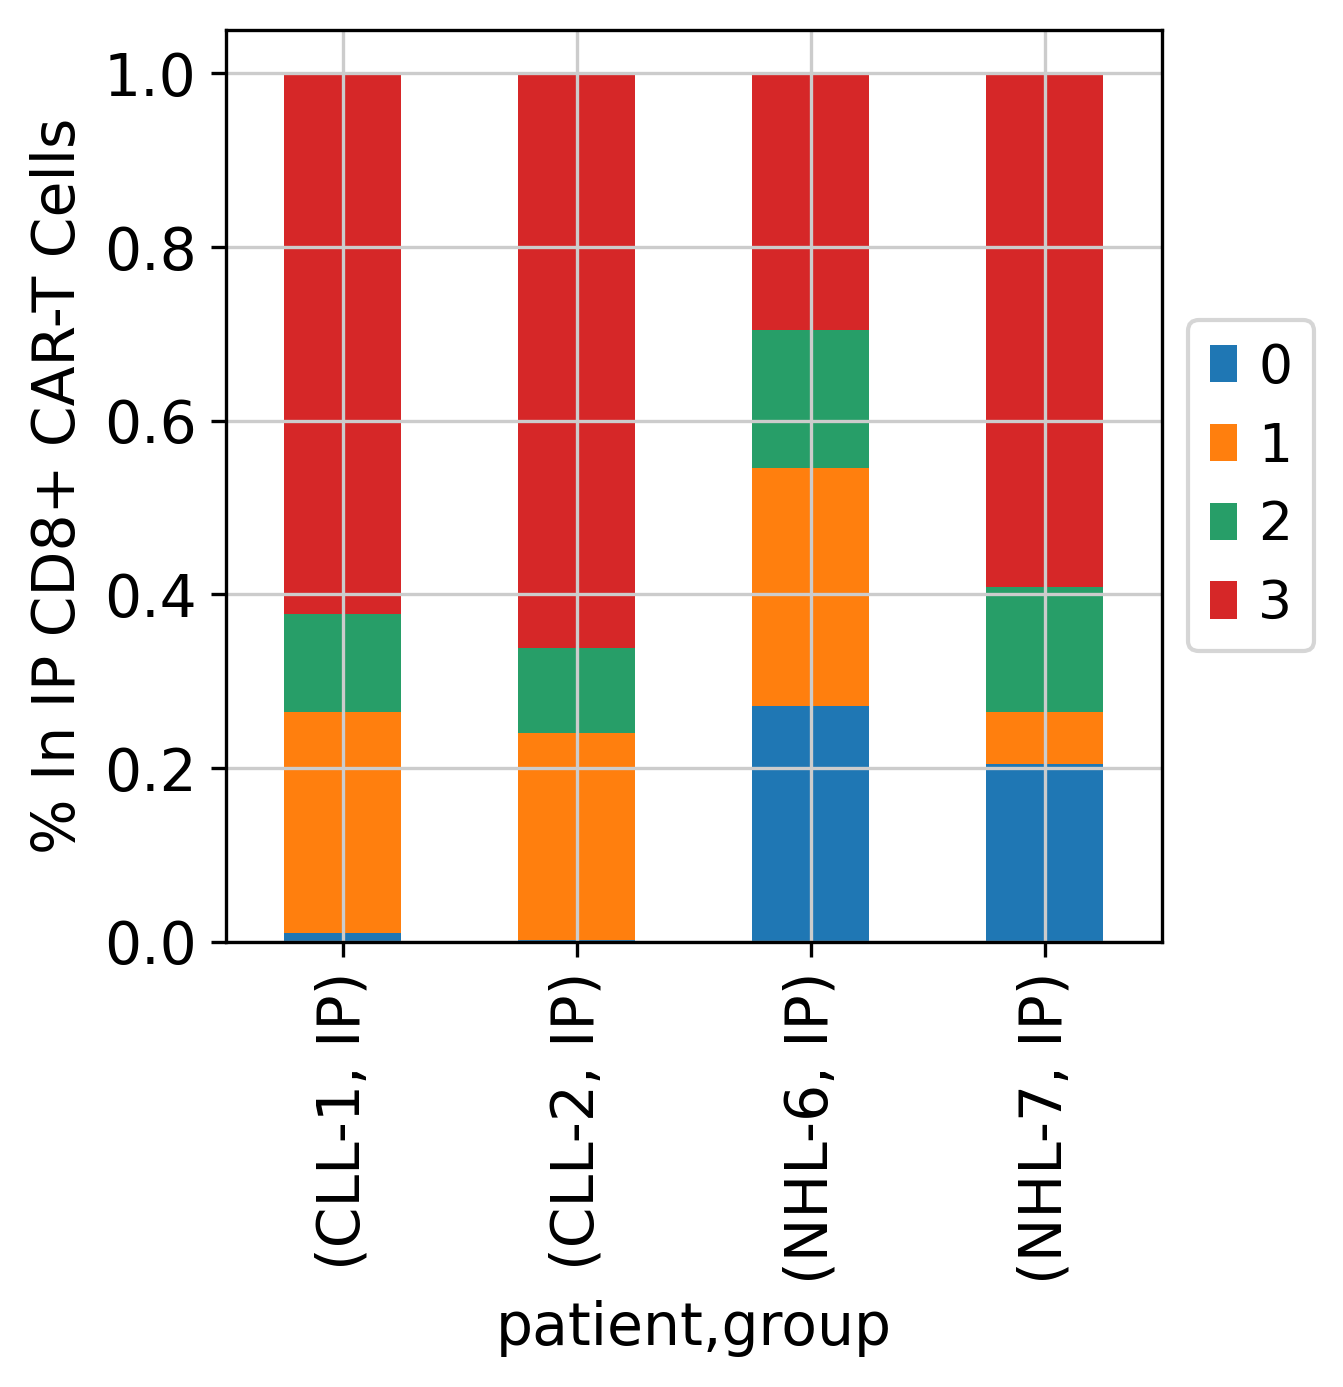

In [ ]:
# Figure C: stacked bar chart as result of percentage of each identified cluster among CD8+ CAR-T cells
# in the IP for each patient

# Generate Stacked Bar Graph of results of kmeans clustering
ax = pct_mat.plot(kind='bar', stacked=True)
plt.ylabel('% In IP CD8+ CAR-T Cells')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
# Figure B final heatmap using ge_test (IP only)

... storing 'kmeans4' as categorical


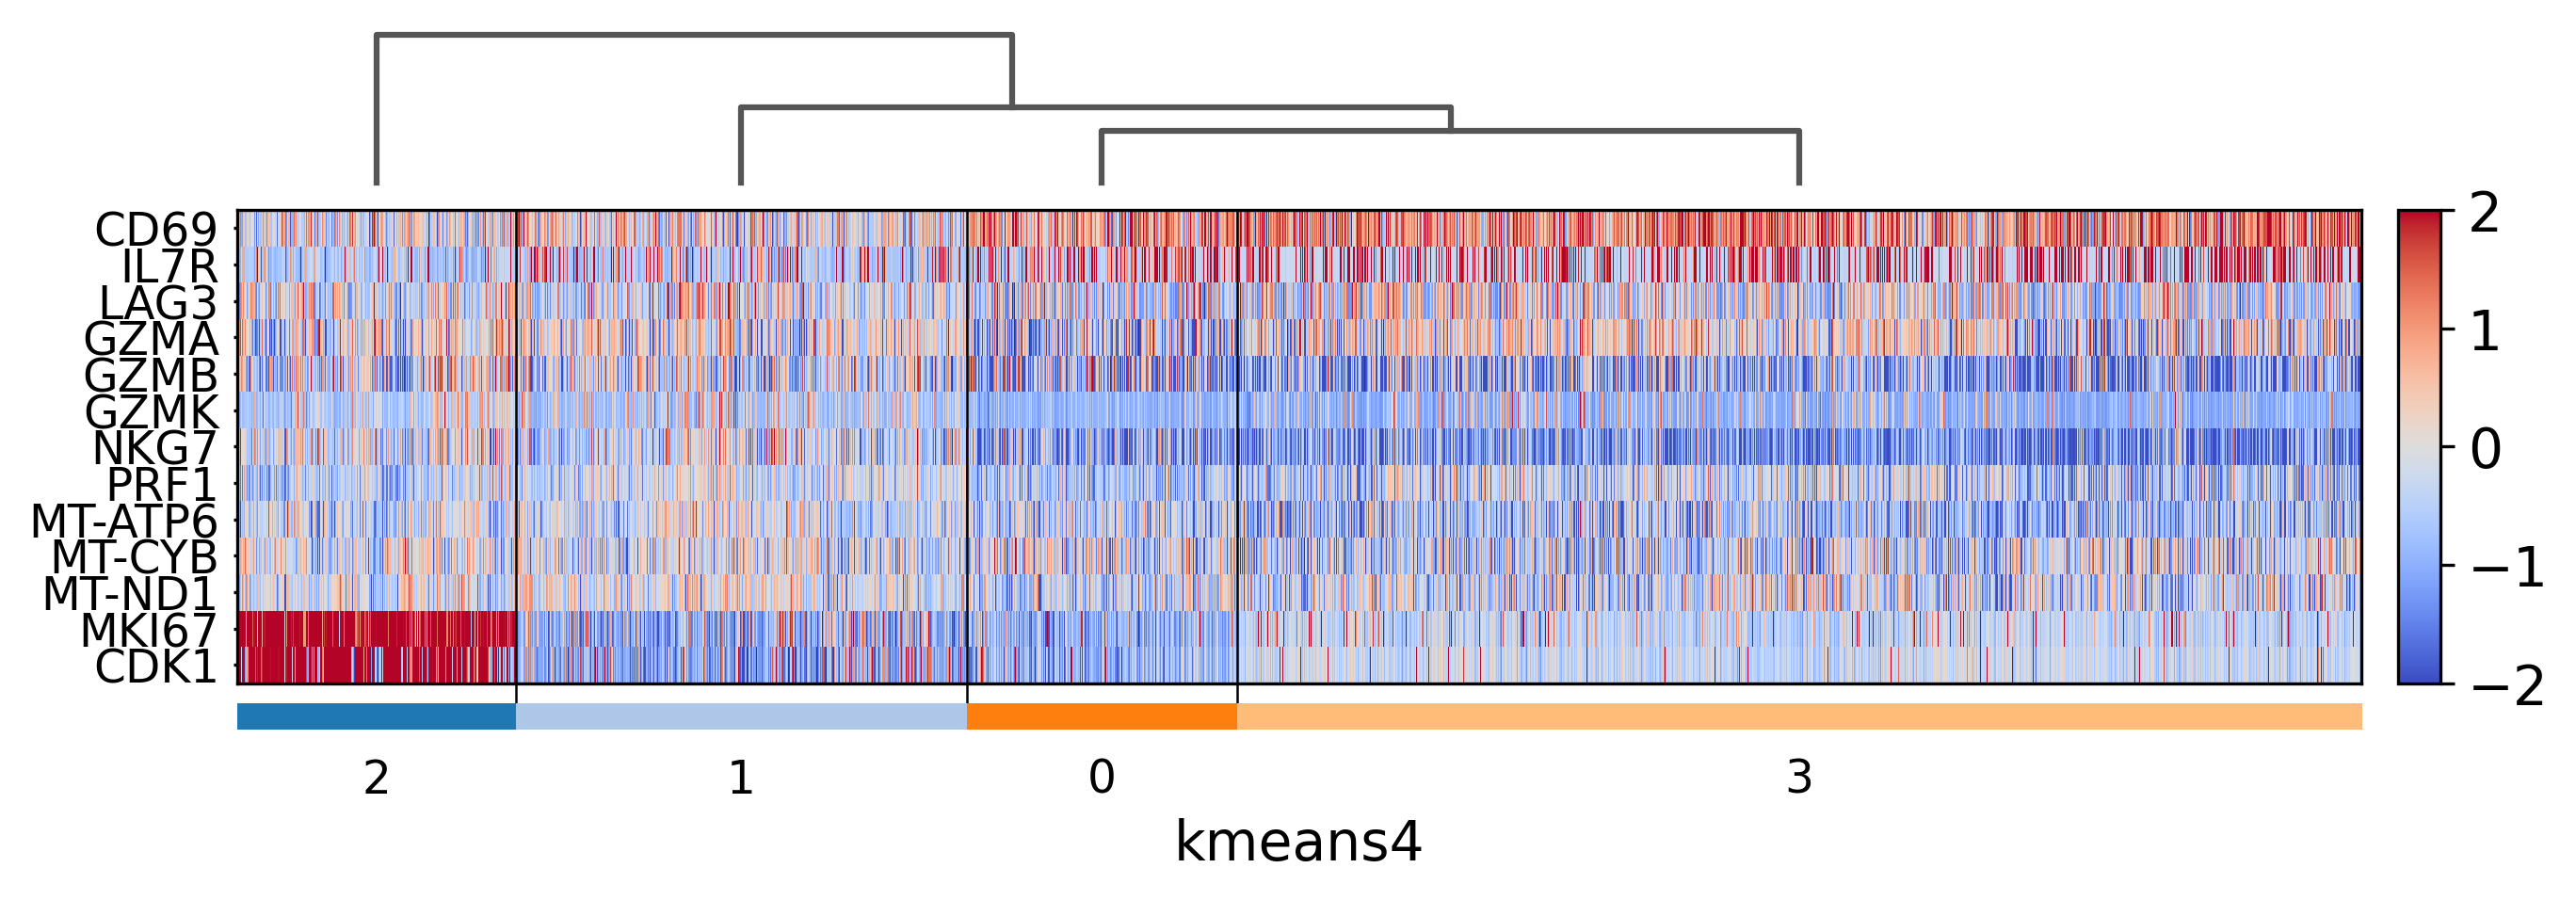

In [ ]:
# Figure 6B

heatmap_fig = ['CD69', 'IL7R', 'LAG3', 'GZMA', 'GZMB', 'GZMK', 'NKG7', 'PRF1', 'MT-ATP6',
                 'MT-CYB', 'MT-ND1', 'MKI67', 'CDK1']
# Genes MT-CO1, CCNA2, and CDCA2 are not found within top_ranked_genes in this dataset for some reason


#Plot the expression values of genes found in IP
sc.pl.heatmap(ge_test, groupby='kmeans4', var_names=heatmap_fig, swap_axes=True, 
              vmin =-2, vmax=2, dendrogram=True, use_raw=False, show_gene_labels=True, cmap='coolwarm')